<a href="https://colab.research.google.com/github/shay-dan/DS_workshop_OpenUIL/blob/main/Prediction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6.Prediction:  Presentation of the Models

We are going to our several models for image classification task. Before we are using them we will explain briefly on each one for them:

1. **Stochastic Gradient Descent (SGD):**
   An optimization algorithm commonly used for training neural networks. It updates model parameters based on the gradient of the loss function with respect to the parameters. In the context of image classification, SGD is often employed to minimize the classification error by adjusting the weights of a neural network.

2. **Support Vector Machine (SVM):**
   A powerful machine learning algorithm for classification tasks. In image classification, SVM can be used with various kernel functions to find an optimal hyperplane that separates different classes in the feature space, making it effective for high-dimensional data like image features.

3. **Grid Search:**
   A hyperparameter tuning technique where a predefined set of hyperparameter values are systematically tested to find the combination that results in the best model performance. In image classification, grid search can be applied to optimize parameters like learning rates or kernel sizes for different models.

4. **Random Forest:**
   An ensemble learning method that constructs a multitude of decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. In image classification, Random Forest can be applied to a set of image features to make accurate predictions.

5. **VGG16:**
   A deep convolutional neural network architecture with 16 weight layers, known for its simplicity and effectiveness in image classification tasks. It consists of multiple convolutional layers followed by fully connected layers. VGG16 has been widely used in computer vision for image classification due to its ability to capture complex hierarchical features.

After finishing the classification, we are going to use 2 object detection models that will help to estimate the weight (the class) for each object in each image.

Something to be taken to consideration is that in classifing we used class "mix" and ignored "coin" altogether, but in doing object detection we broke "mix" to its object instances and detected coins in every image.

We used the following object detection models:

**DETECTRON2** and **YOLOv8**.

the models were chosen as they are easy to use, fast to train (transfer learning on pretrained weights) and provide excellent results.

**Detectron2 (2019):** developed by Facebook AI Research (FAIR/Meta AI). It is built on PyTorch (Caffe2 library) and provides a modular and flexible platform for developing and training object detection (our choice), instance segmentation and panoptic segmentation models.

It works by first extracting features from an input image using a convolutional neural network (CNN). These features are then used to predict the bounding boxes and class labels of the objects present in the image.

The main components of Detectron2 are:

* Backbone network: pretrained CNN that extracts features from the input image. (weights for multiple models are available)

* Region Proposal Network (RPN): for generating candidate object bounding boxes.

* Object detector: classifies the candidate bounding boxes and assigns class labels.

**YOLOv8 (2023):** YOLO - "You Only Look Once" is a family of real-time object detection models developed by Ultralytics (2015-2024). YOLOv8 is one of latest versions, and can be used for object detection, instance segmentation, and more. YOLO models are among the fastest object detection algorithms, while still being very accurate.

It works by dividing the input image into a grid and predicts bounding boxes and class probabilities for each grid cell.

The main components of YOLOv8 are:

* Backbone Network: used to extract features from the input image. uses  CSPDarknet53 backbone network by default.
* Neck Network: further processes the features from the backbone network and outputs feature maps to be used for object detection. YOLOv8 uses a PAN (Path Aggregation Network) neck network by default.
* Head Network: predicts bounding boxes and class probabilities for objects in the image. YOLOv8 uses a YOLOHead network by default.
* Loss Function: used to train the network. YOLOv8 uses a combination of binary cross-entropy loss and IoU loss (DF loss).


For the final stage of our pipeline, we will use the predicted bounding boxes as input to **SAM** model, to get its prediction masks to help us incearse our accuracy in the weight estimation.

**Segment Anything Model (SAM) (2023):**
developed by Facebook AI Research (FAIR/Meta AI), it can "cut out" any object, in any image, without training on the specific data (Zero-shot generalization, as it was trained on over 11 million images and over a billion(!) masks) .
SAM "learned" a general notion of what objects are, and it can generate masks with different prompts such as points, bboxes, and even text. we will use our predicted bboxes as its input.





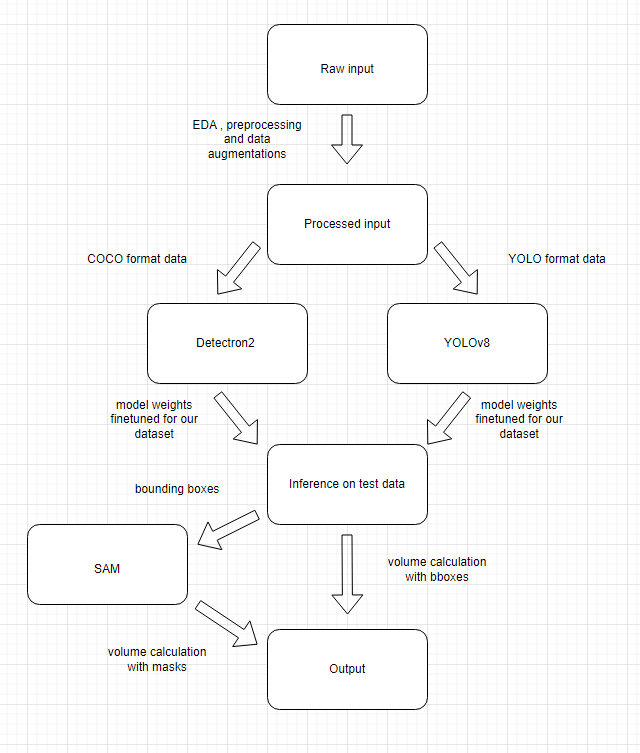

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import seaborn as sns
sns.set(style = "dark",
        color_codes = True,
        font_scale = 1.5)
import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil
import logging
logging.getLogger().setLevel(logging.CRITICAL)
!pip install pylabel > /dev/null
from pylabel import importer
import os
import shutil
import glob

In [ ]:
!nvidia-smi

Fri Jan 19 13:43:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We will classify our dataset using several approaches:
1. we will use HOG features and several learning algorithms (SGD,SVM) to build a simple classifier without the use of deep learning
2. we will use PCA on extracted features and run Random Forest classifer as well
3. we will use a pretrained NN and classify
Next, we will use SOTA (state of the art, or once of the very best) object detection models as we also want the measurements of the objects:
1. Detectron2
2. YOLOv8

#6.1.Classification:

## Stochastic Gradient Descent with HOG descriptors:

We start by using the old school approach:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pprint

In [ ]:
import joblib
from skimage.io import imread
from skimage.transform import resize

def resize_all(src, pklname, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary,
    together with labels and metadata. The dictionary is written to a pickle file
    named '{pklname}_{width}x{height}px.pkl'.

    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """

    height = height if height is not None else width

    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []

    pklname = f"{pklname}_{width}x{height}px.pkl"

    # read all images in PATH, resize and write to DESTINATION_PATH
    current_path = src
    for file in os.listdir(current_path):
        if file[-3:] in {'JPG'}:
            im = imread(os.path.join(current_path, file))
            im = resize(im, (width, height))
            tmp = file.split("0")[0].split("_")[-1]
            if tmp =='twist':
              data['label'].append("fired_dough_twist")
            else:
              data['label'].append(tmp)
            data['filename'].append(file)
            data['data'].append(im)

    joblib.dump(data, pklname)

In [ ]:
shutil.copytree("/content/drive/MyDrive/dataset_augmented/train", "/content/train")
for file in os.listdir("/content/drive/MyDrive/dataset_augmented/val"):
  shutil.copyfile("/content/drive/MyDrive/dataset_augmented/val/" + file, "/content/train/" + file)
shutil.copytree("/content/drive/MyDrive/dataset_augmented/test", "/content/test")

'/content/test'

We resize our dataset to 80x80, keeping it in the original size crushes colab due to lack of RAM. 80x80 is still enough to use the HOG discriptors.

We split our data to our train + val sets as train set, and test as is. That way we could compare all our models.

In [ ]:
data_path = '/content/train'
os.listdir(data_path)
base_name = 'images_train'
width = 80
resize_all(src=data_path, pklname=base_name, width=width)

In [ ]:
from collections import Counter

data = joblib.load("/content/images_train_80x80px.pkl")

print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))

Counter(data['label'])

number of samples:  6100
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) images in rgb
image shape:  (80, 80, 3)
labels: ['apple' 'banana' 'bread' 'bun' 'doughnut' 'egg' 'fired_dough_twist'
 'grape' 'lemon' 'litchi' 'mango' 'mix' 'mooncake' 'orange' 'peach' 'pear'
 'plum' 'qiwi' 'sachima' 'tomato']


Counter({'egg': 305,
         'orange': 305,
         'doughnut': 305,
         'peach': 305,
         'apple': 305,
         'grape': 305,
         'bun': 305,
         'qiwi': 305,
         'litchi': 305,
         'bread': 305,
         'banana': 305,
         'plum': 305,
         'sachima': 305,
         'fired_dough_twist': 305,
         'tomato': 305,
         'lemon': 305,
         'mooncake': 305,
         'mix': 305,
         'pear': 305,
         'mango': 305})

In [ ]:
X_train = np.array(data['data'])
y_train = np.array(data['label'])

In [ ]:
data_path = '/content/test'
os.listdir(data_path)
base_name = 'images_test'
width = 80
resize_all(src=data_path, pklname=base_name, width=width)

In [ ]:
from collections import Counter

data = joblib.load("/content/images_test_80x80px.pkl")

print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))

Counter(data['label'])

number of samples:  200
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) images in rgb
image shape:  (80, 80, 3)
labels: ['apple' 'banana' 'bread' 'bun' 'doughnut' 'egg' 'fired_dough_twist'
 'grape' 'lemon' 'litchi' 'mango' 'mix' 'mooncake' 'orange' 'peach' 'pear'
 'plum' 'qiwi' 'sachima' 'tomato']


Counter({'tomato': 10,
         'doughnut': 10,
         'sachima': 10,
         'grape': 10,
         'qiwi': 10,
         'litchi': 10,
         'egg': 10,
         'mix': 10,
         'peach': 10,
         'lemon': 10,
         'orange': 10,
         'plum': 10,
         'fired_dough_twist': 10,
         'apple': 10,
         'mooncake': 10,
         'bun': 10,
         'pear': 10,
         'mango': 10,
         'banana': 10,
         'bread': 10})

In [ ]:
X_test = np.array(data['data'])
y_test = np.array(data['label'])

Now we use a pipeline, we convert to grayscale, extract HOG discriptos, HOG images.

In [ ]:
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])


class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)

        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

class HogImage(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            vec, im = hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm,
                       visualize = True)
            return im
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

We pass our data through a pipeline that extracts HOG features.

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer

import skimage

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
imify = HogImage(
    pixels_per_cell=(14, 14),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()

# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_hog_im = imify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

print(X_train_prepared.shape)

(6100, 576)


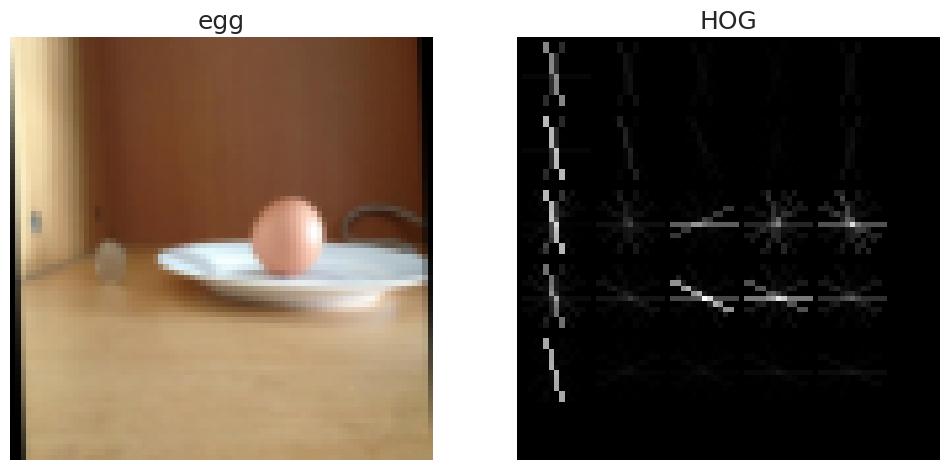

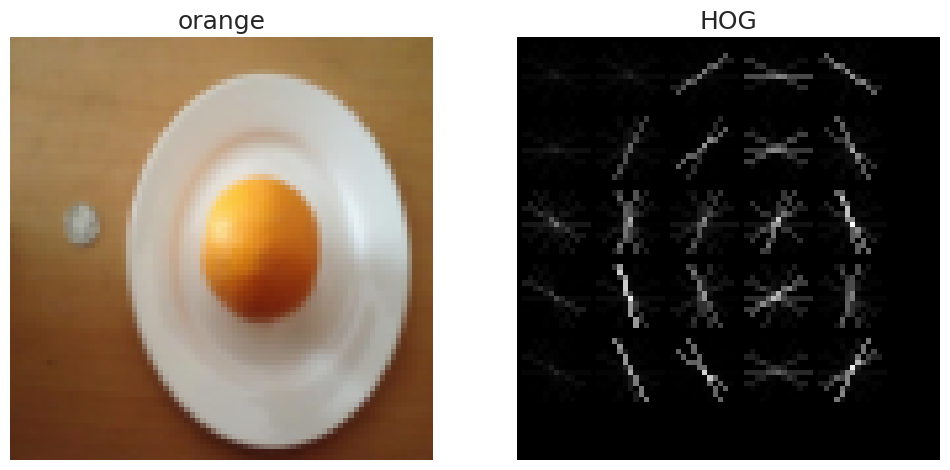

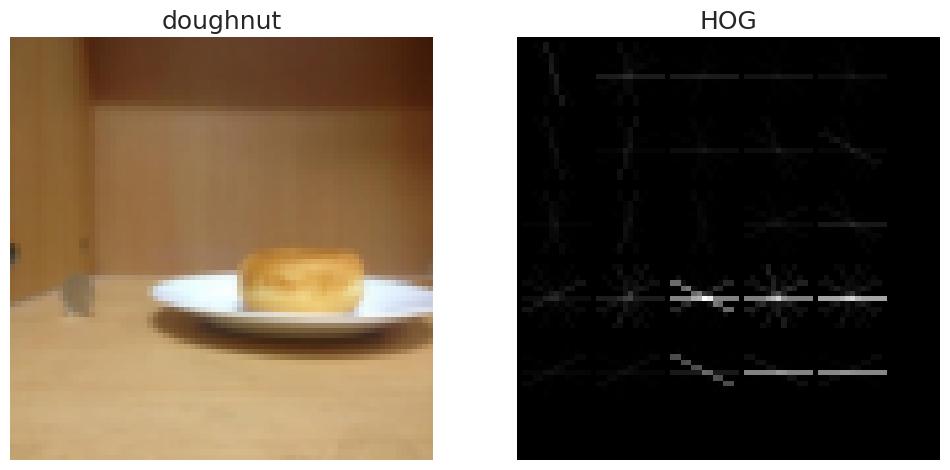

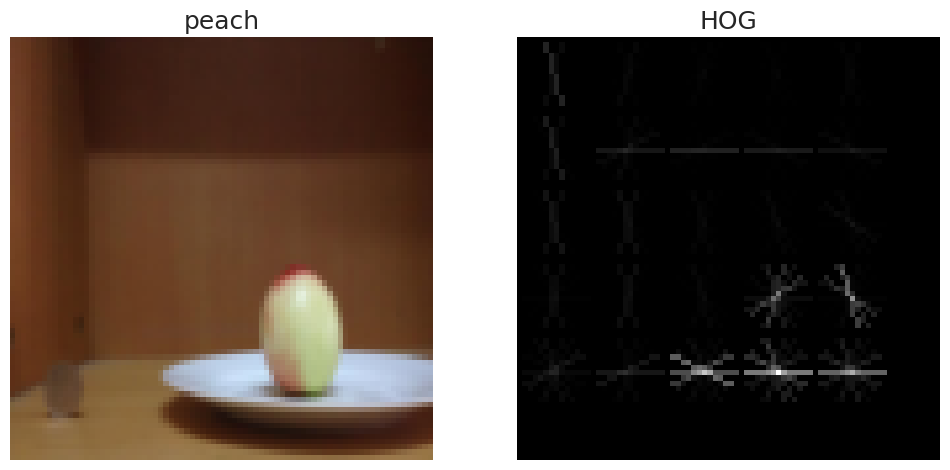

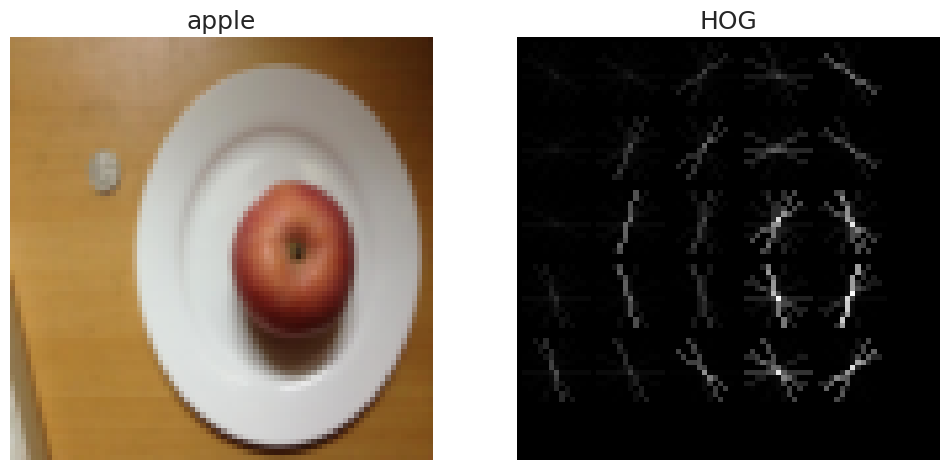

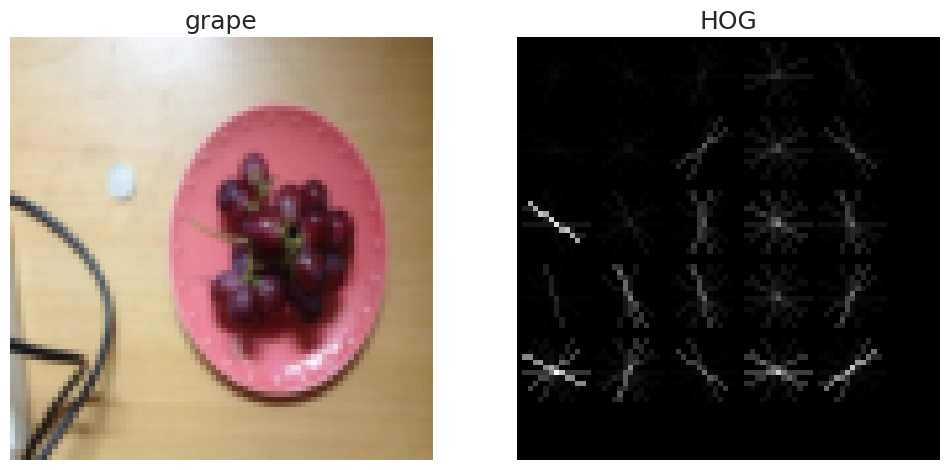

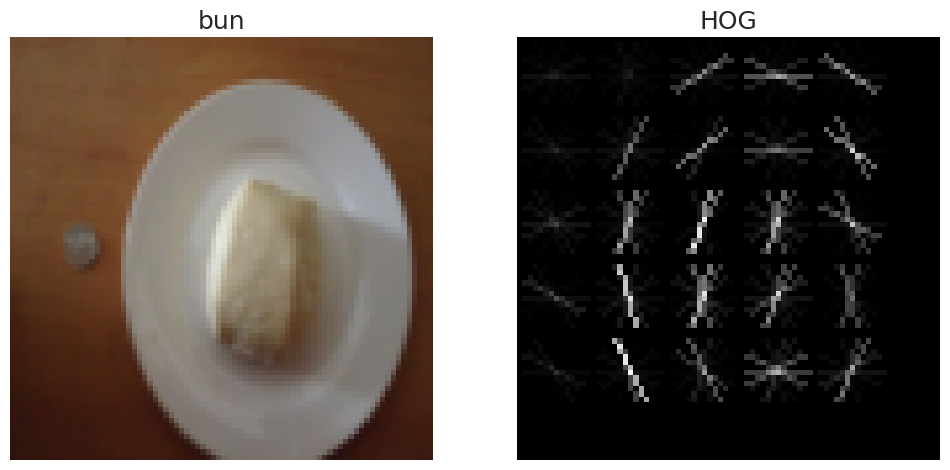

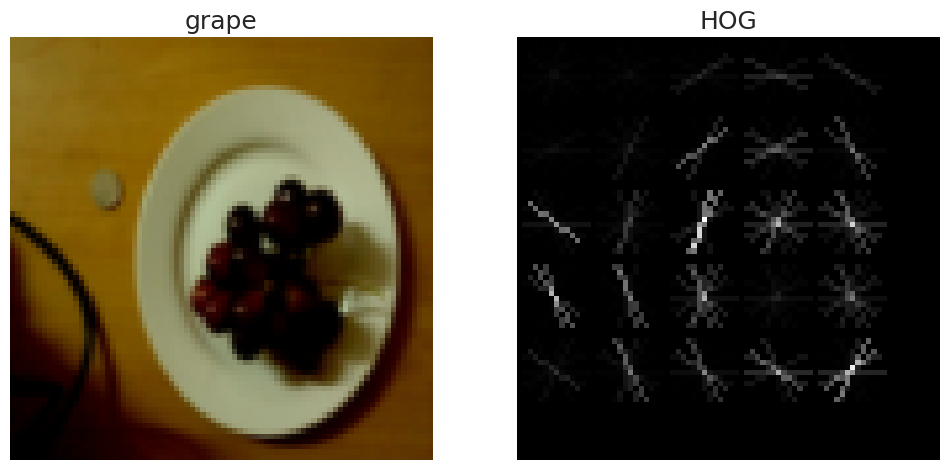

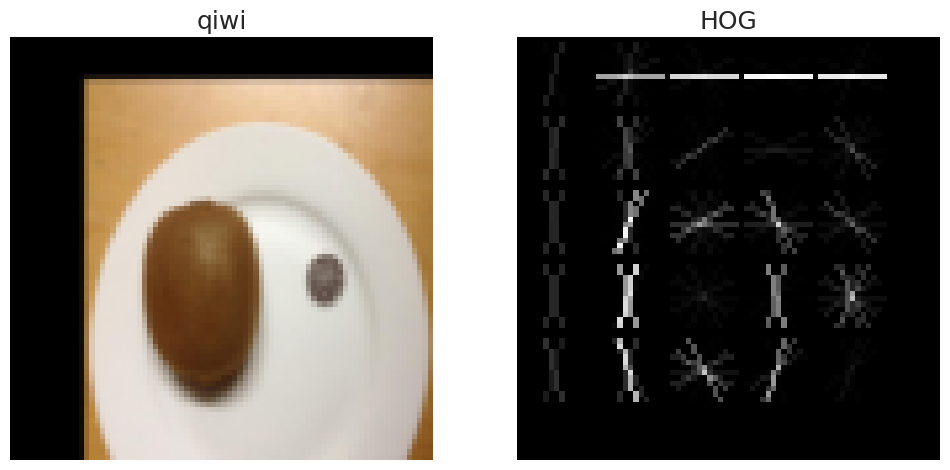

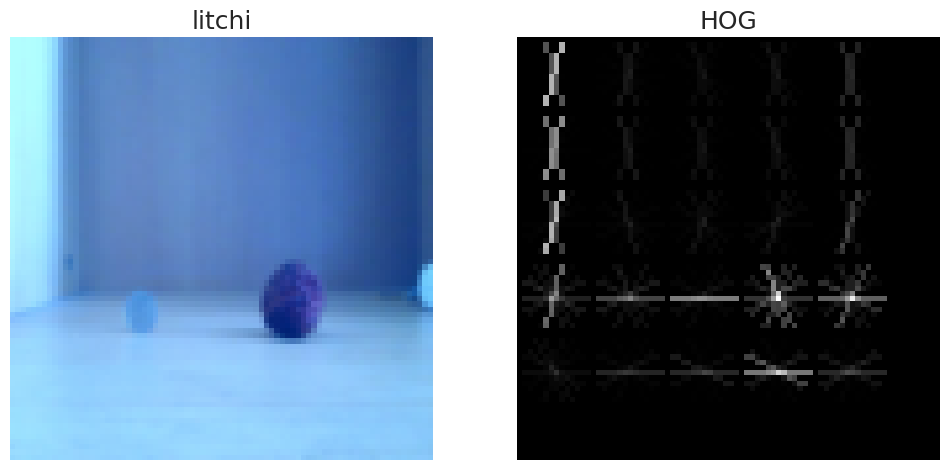

In [ ]:
for i in range(10):
  fig, ax = plt.subplots(figsize=(12, 12), ncols=2)
  ax[0].imshow(X_train[i])
  ax[0].set_title(y_train[i])
  ax[0].axis('off')
  ax[1].imshow(X_train_hog_im[i], cmap='gray')
  ax[1].set_title('HOG')
  ax[1].axis('off')
  plt.show()


We start by using SGD learning algorithm

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=2000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(max_iter=2000, random_state=42)

In [ ]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_hog_im = imify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [ ]:
y_pred = sgd_clf.predict(X_test_prepared)
sgd_acc_score = 100*np.sum(y_pred == y_test)/len(y_test)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  55.0


<Axes: >

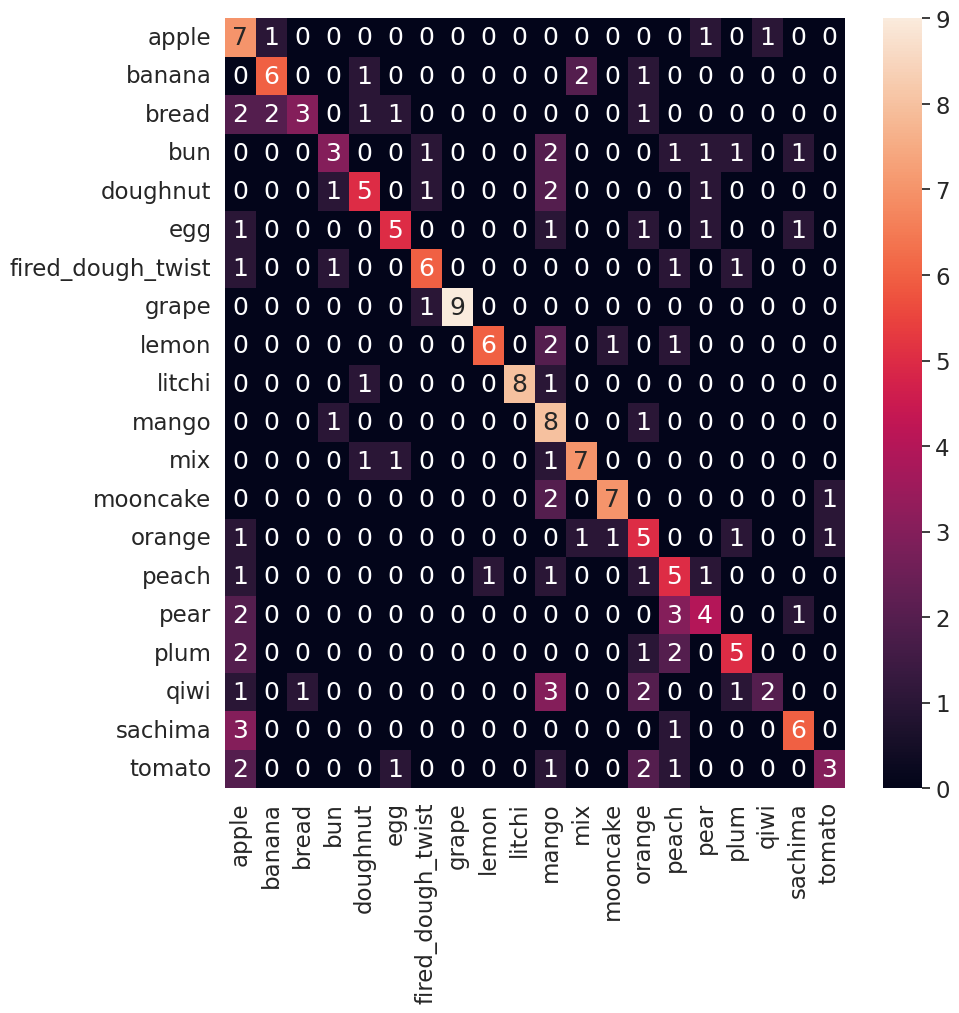

In [ ]:
from sklearn.metrics import confusion_matrix
sgd_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(sgd_cm, annot=True, xticklabels=sorted(np.unique(y_test)), yticklabels=sorted(np.unique(y_test)))

In the above plot and the following plots we have "Ground Truth" on the vertical axis (y-axis) and "Prediction" on the horizontal axis (x-axis)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
cls = list(sorted(np.unique(y_test)))

In [ ]:
sgd_cr = classification_report(y_test, y_pred, output_dict=False, target_names=cls)
print(sgd_cr)

                   precision    recall  f1-score   support

            apple       0.30      0.70      0.42        10
           banana       0.67      0.60      0.63        10
            bread       0.75      0.30      0.43        10
              bun       0.50      0.30      0.37        10
         doughnut       0.56      0.50      0.53        10
              egg       0.62      0.50      0.56        10
fired_dough_twist       0.67      0.60      0.63        10
            grape       1.00      0.90      0.95        10
            lemon       0.86      0.60      0.71        10
           litchi       1.00      0.80      0.89        10
            mango       0.33      0.80      0.47        10
              mix       0.70      0.70      0.70        10
         mooncake       0.78      0.70      0.74        10
           orange       0.33      0.50      0.40        10
            peach       0.33      0.50      0.40        10
             pear       0.44      0.40      0.42       

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import svm

HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14),
        cells_per_block=(2, 2),
        orientations=9,
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=2000, tol=1e-3))
])

clf = HOG_pipeline.fit(X_train, y_train)
sgd_pipeline_score = 100*np.sum(clf.predict(X_test) == y_test)/len(y_test)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  55.0


We used HOG features and classified using SGD, we got bad results, not much better than random coin flips. Let's see how we can improve.

## Support Vector Machine with Grid Search on HOG descriptors:

Let's do gridsearch to find our best option:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=2000, tol=1e-3),
             svm.SVC(kernel='linear'),
         ]
    }
]

In [ ]:
grid_search = GridSearchCV(HOG_pipeline,
                           param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)

grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [ ]:
joblib.dump(grid_res, '/content/drive/MyDrive/ColabNotebooks/models/hog_param_search_model.pkl')
data = joblib.load('/content/drive/MyDrive/ColabNotebooks/models/hog_param_search_model.pkl')
print(data)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                                       ('hogify',
                                        HogTransformer(cells_per_block=(2, 2),
                                                       pixels_per_cell=(14,
                                                                        14))),
                                       ('scalify', StandardScaler()),
                                       ('classify',
                                        SGDClassifier(max_iter=2000,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'hogify__cells_per_block': [(2, 2), (3, 3)],
                          'hogify__orientations': [8, 9],
                          'hogify__pixels_per_cell': [(8, 8), (10, 10),
                                                      (12, 12)]},
                         {'classify': [SGDClassifier(max_iter=200

In [ ]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

In [ ]:
# the highscore during the search
grid_res.best_score_

0.7355728158282472

In [ ]:
best_pred = grid_res.predict(X_test)
grid_search_score = 100*np.sum(best_pred == y_test)/len(y_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  77.0


Using grid search we improved our predictions by 22%!

<Axes: >

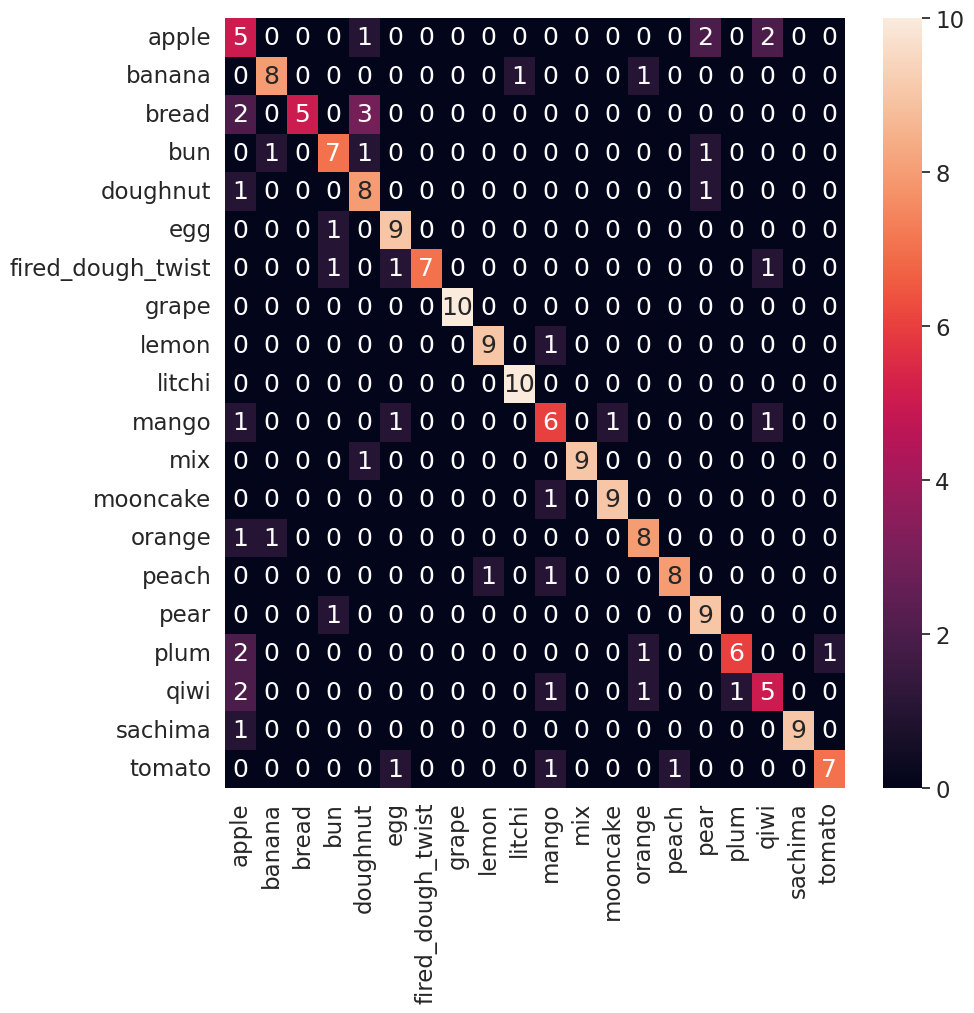

In [ ]:
cmx_svm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cmx_svm, annot=True, xticklabels=sorted(np.unique(y_test)), yticklabels=sorted(np.unique(y_test)))

In [ ]:
svm_cr = classification_report(y_test, y_pred, output_dict=False, target_names=cls)
print(svm_cr)

                   precision    recall  f1-score   support

            apple       0.30      0.70      0.42        10
           banana       0.67      0.60      0.63        10
            bread       0.75      0.30      0.43        10
              bun       0.50      0.30      0.37        10
         doughnut       0.56      0.50      0.53        10
              egg       0.62      0.50      0.56        10
fired_dough_twist       0.67      0.60      0.63        10
            grape       1.00      0.90      0.95        10
            lemon       0.86      0.60      0.71        10
           litchi       1.00      0.80      0.89        10
            mango       0.33      0.80      0.47        10
              mix       0.70      0.70      0.70        10
         mooncake       0.78      0.70      0.74        10
           orange       0.33      0.50      0.40        10
            peach       0.33      0.50      0.40        10
             pear       0.44      0.40      0.42       

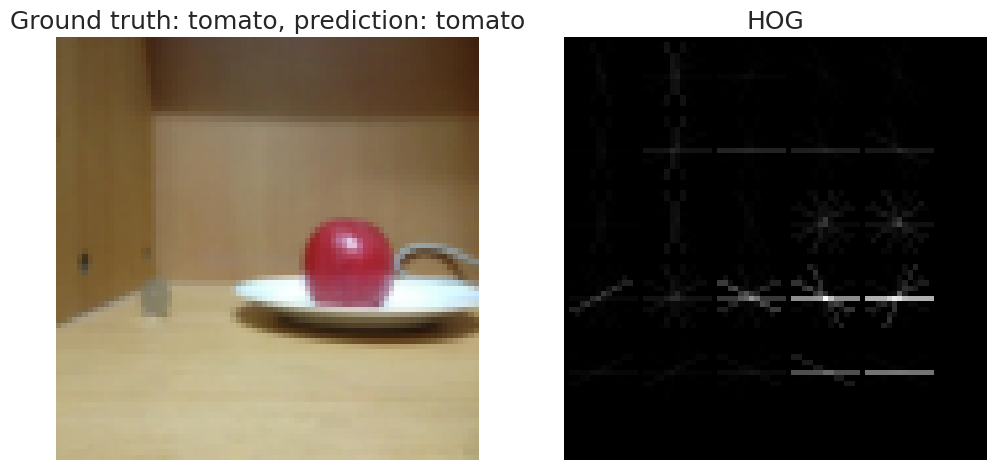

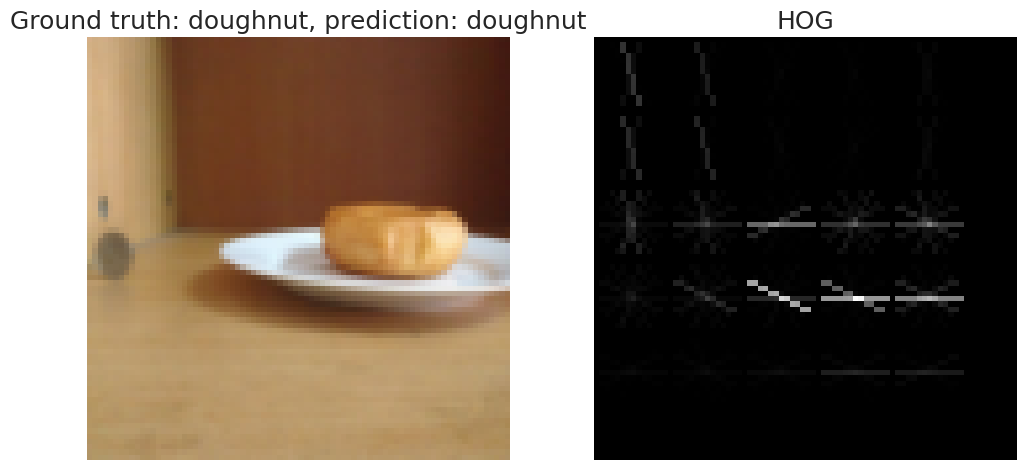

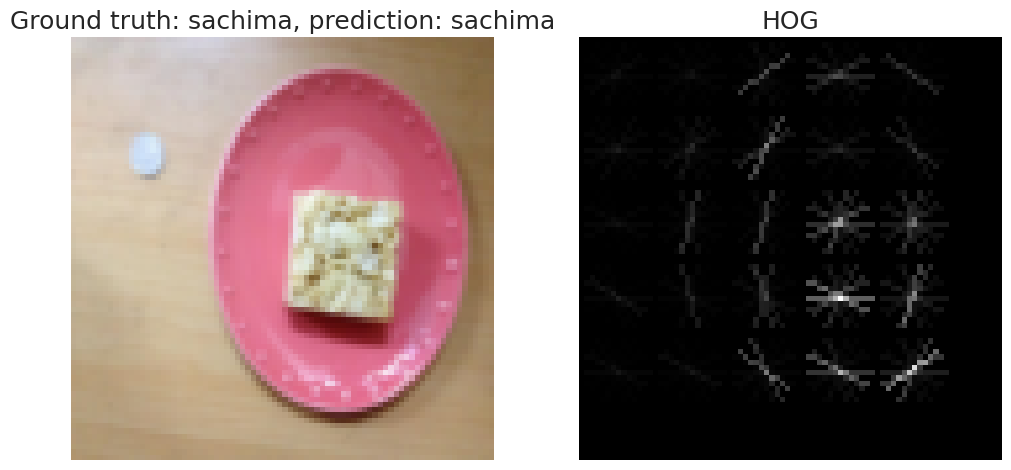

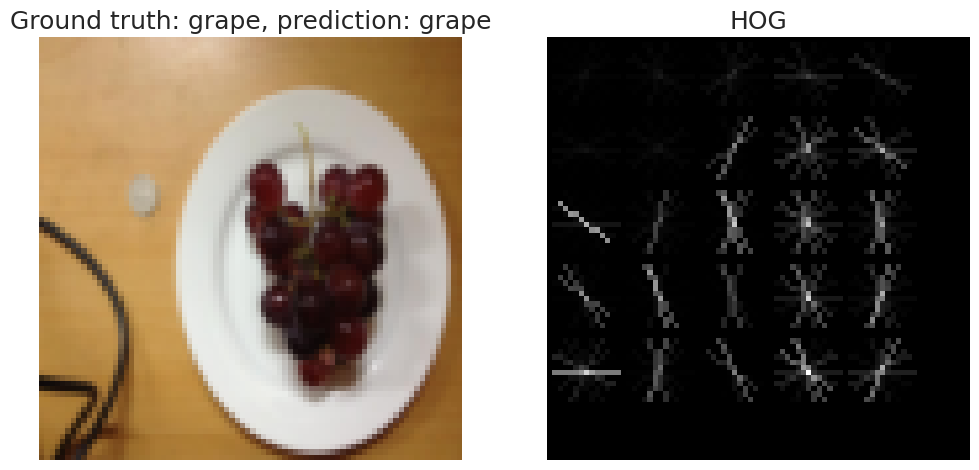

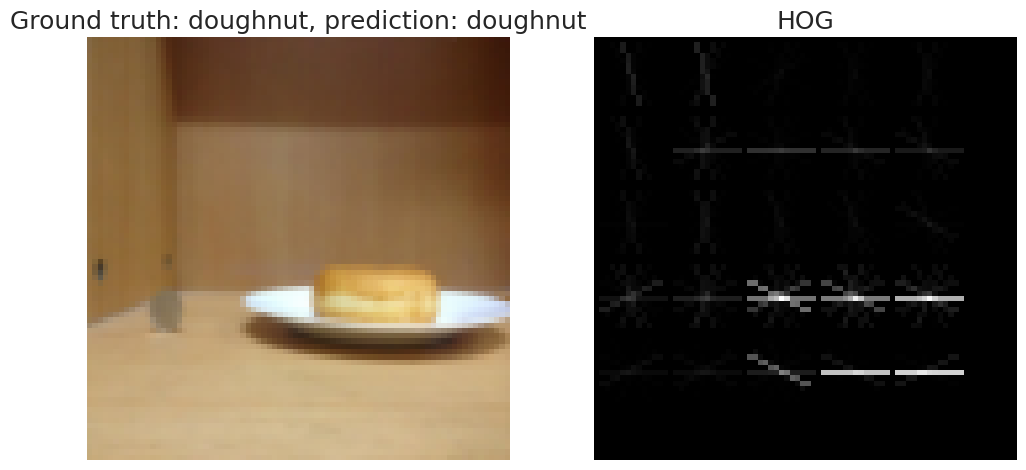

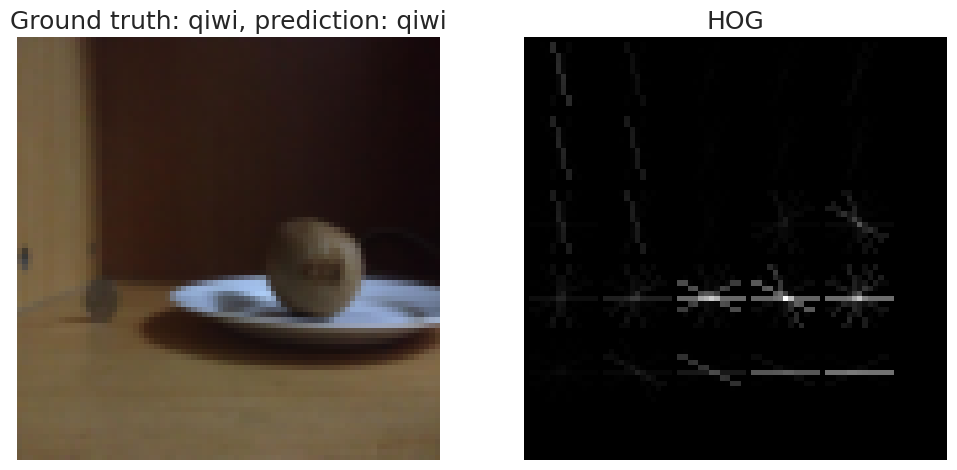

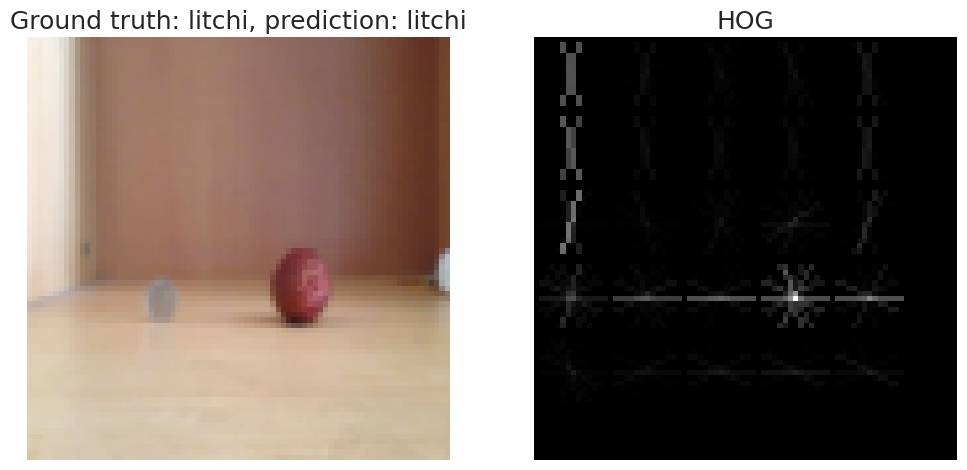

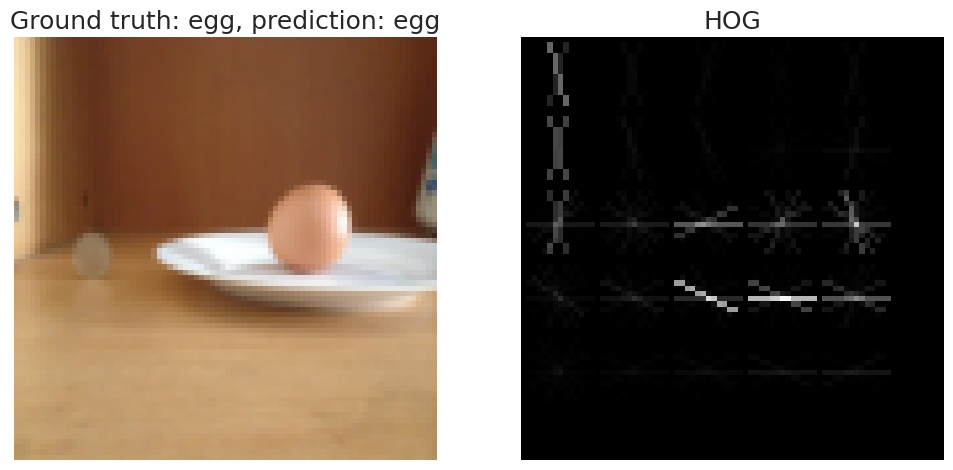

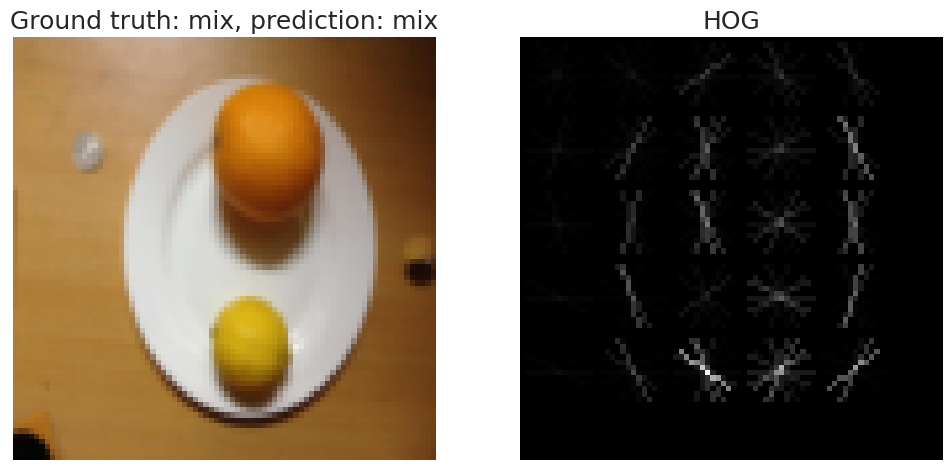

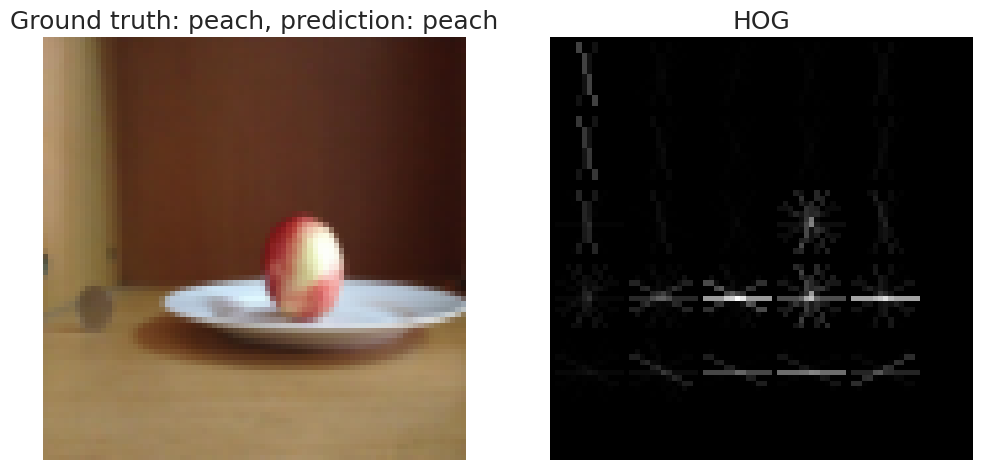

In [ ]:
for i in range(10):
  fig, ax = plt.subplots(figsize=(12, 12), ncols=2)
  ax[0].imshow(X_test[i])
  ax[0].set_title("Ground truth: " + y_test[i] + ", prediction: " + best_pred[i])
  ax[0].axis('off')
  ax[1].imshow(X_test_hog_im[i], cmap='gray')
  ax[1].set_title('HOG')
  ax[1].axis('off')
  plt.show()

Now let's save our results to disk so we can compare in the future

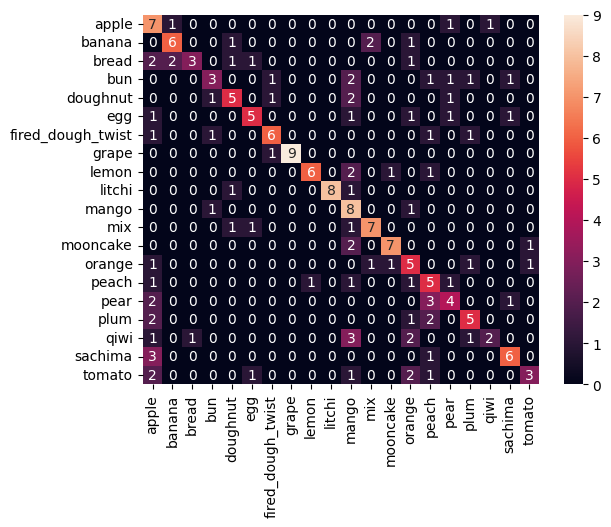

In [ ]:
sns.heatmap(sgd_cm, annot=True, xticklabels=sorted(cls), yticklabels=sorted(cls))
plt.savefig('/content/drive/MyDrive/ColabNotebooks/models/confusion_matrix_sgd.jpg')

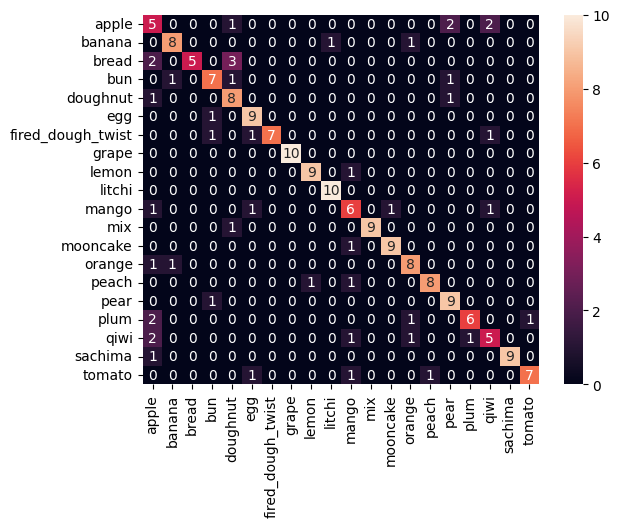

In [ ]:
sns.heatmap(cmx_svm, annot=True, xticklabels=sorted(cls), yticklabels=sorted(cls))
plt.savefig('/content/drive/MyDrive/ColabNotebooks/models/confusion_matrix_svm.jpg')

In [ ]:
import pickle

with open('/content/drive/MyDrive/ColabNotebooks/models/sgd_svm_results.pkl', 'wb') as f:
    pickle.dump([sgd_acc_score, sgd_cm, sgd_cr, grid_res.best_estimator_, grid_res.best_score_,grid_search_score,cmx_svm,svm_cr], f)

with open('/content/drive/MyDrive/ColabNotebooks/models/sgd_svm_results.pkl','rb') as f:
    sgd_acc_score, sgd_cm, sgd_cr, grid_res_estimator_, grid_res_best_score_,grid_search_score,cmx_svm,svm_cr = pickle.load(f)

print("\n sgd_acc_score: \n", sgd_acc_score)
print("\n sgd_cm \n", sgd_cm)
print("\n sgd_cr: \n", sgd_cr)
print("\n grid_res.best_estimator_ \n", grid_res_estimator_)
print("\n grid_res.best_score_ \n", grid_res_best_score_)
print("\n grid_search_score: \n", grid_search_score)
print("\n cmx_svm: \n", cmx_svm)
print("\n svm_cr: \n", svm_cr)


 sgd_acc_score: 
 55.0

 sgd_cm 
 [[7 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 6 0 0 1 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0]
 [2 2 3 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 3 0 0 1 0 0 0 2 0 0 0 1 1 1 0 1 0]
 [0 0 0 1 5 0 1 0 0 0 2 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 5 0 0 0 0 1 0 0 1 0 1 0 0 1 0]
 [1 0 0 1 0 0 6 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 9 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 6 0 2 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 8 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 8 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 7 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 1 1 5 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 0 1 0 1 0 0 1 5 1 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 0 0 1 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 5 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 3 0 0 2 0 0 1 2 0 0]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 6 0]
 [2 0 0 0 0 1 0 0 0 0 1 0 0 2 1 0 0 0 0 3]]

 sgd_cr: 
                    precision    recall  f1-score   support

            apple       0.30    

## Random Forest with HOG:

Now that we saw that our old school SVM is quite good, we'll try to improve it using Random Forest:

Accuracy =  0.835


<Axes: >

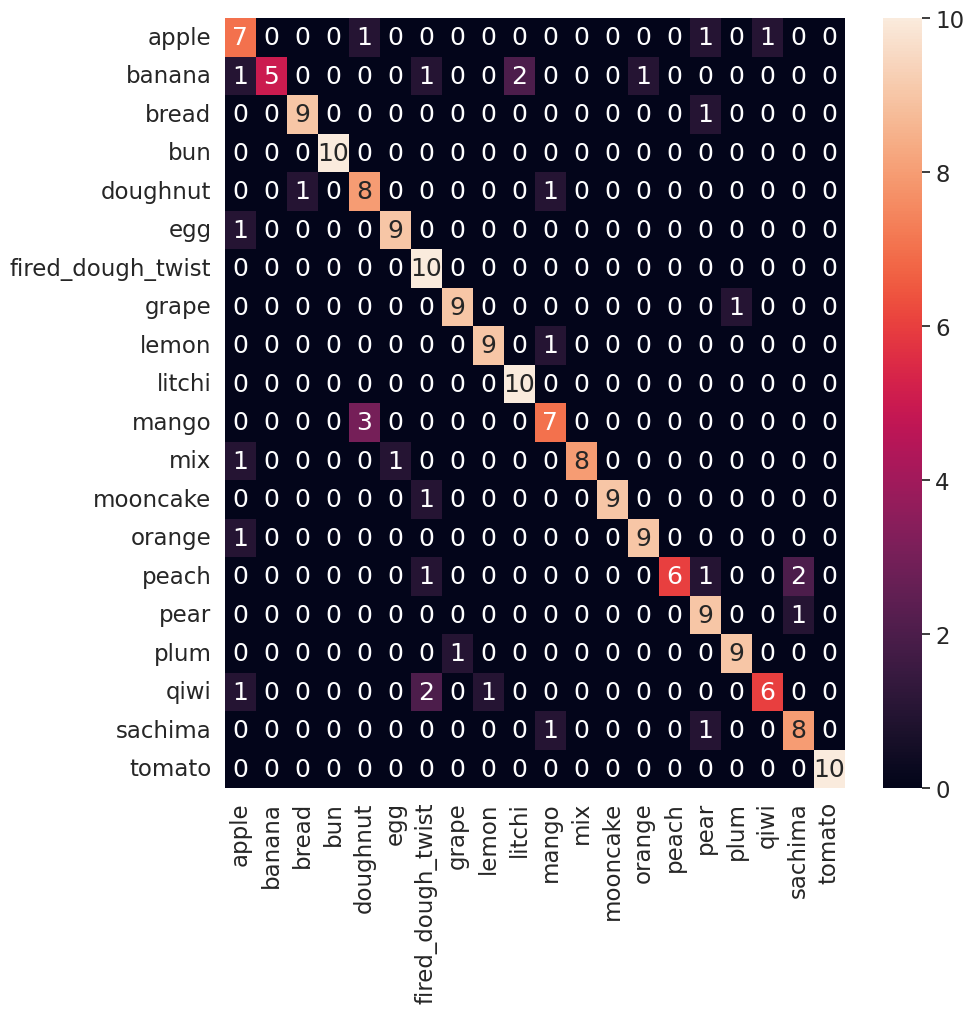

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

X_train_f = X_train.reshape(X_train_prepared.shape[0], -1)
RF_model.fit(X_train_f, y_train)

X_test_f = X_test.reshape(X_test_prepared.shape[0], -1)
prediction_RF = RF_model.predict(X_test_f)
rf_hog =  metrics.accuracy_score(y_test, prediction_RF)
print("Accuracy = ", rf_hog)

cm_rf_hog_data = confusion_matrix(y_test, prediction_RF)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_rf_hog_data, annot=True, xticklabels=sorted(np.unique(y_test)), yticklabels=sorted(np.unique(y_test)))

In [ ]:
rf_hog_cr = classification_report(y_test, prediction_RF, output_dict=False, target_names=cls)
print(rf_hog_cr)

                   precision    recall  f1-score   support

            apple       0.58      0.70      0.64        10
           banana       1.00      0.50      0.67        10
            bread       0.90      0.90      0.90        10
              bun       1.00      1.00      1.00        10
         doughnut       0.67      0.80      0.73        10
              egg       0.90      0.90      0.90        10
fired_dough_twist       0.67      1.00      0.80        10
            grape       0.90      0.90      0.90        10
            lemon       0.90      0.90      0.90        10
           litchi       0.83      1.00      0.91        10
            mango       0.70      0.70      0.70        10
              mix       1.00      0.80      0.89        10
         mooncake       1.00      0.90      0.95        10
           orange       0.90      0.90      0.90        10
            peach       1.00      0.60      0.75        10
             pear       0.69      0.90      0.78       

Actually a decent classifier, with 83.5% acuuracy, a little better than SVM.

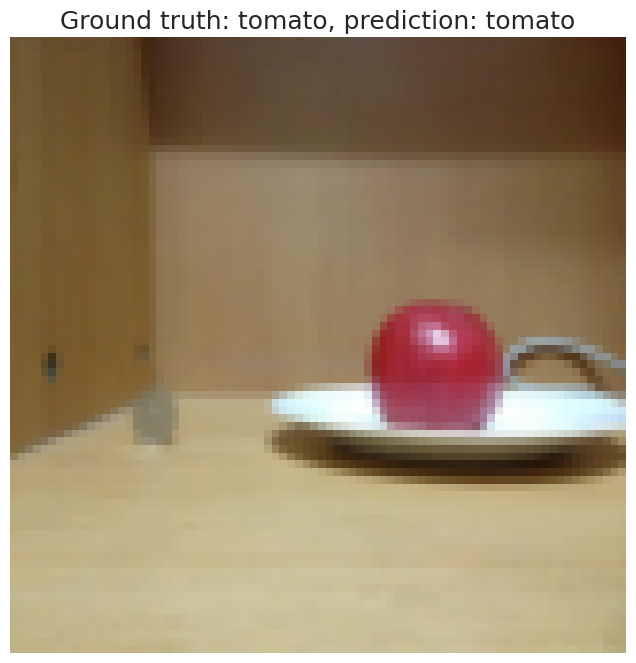

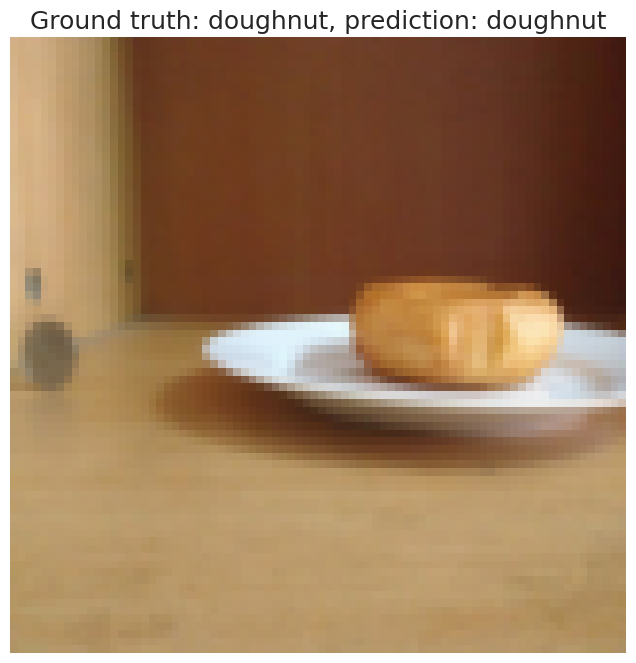

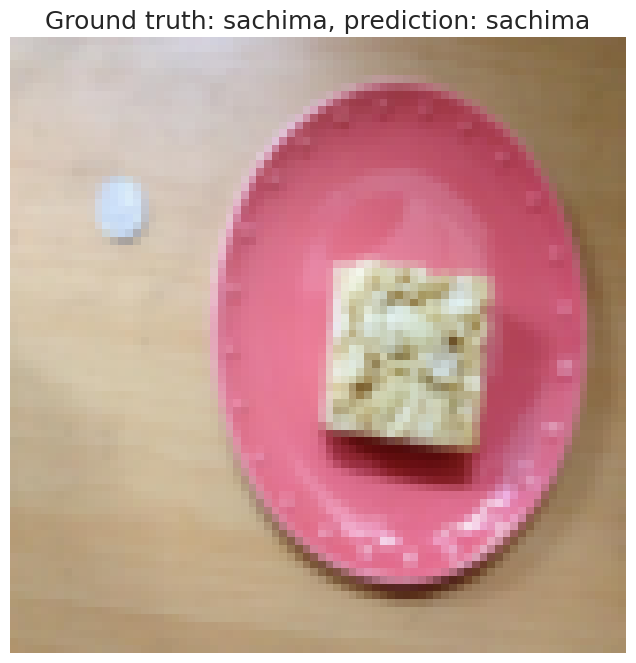

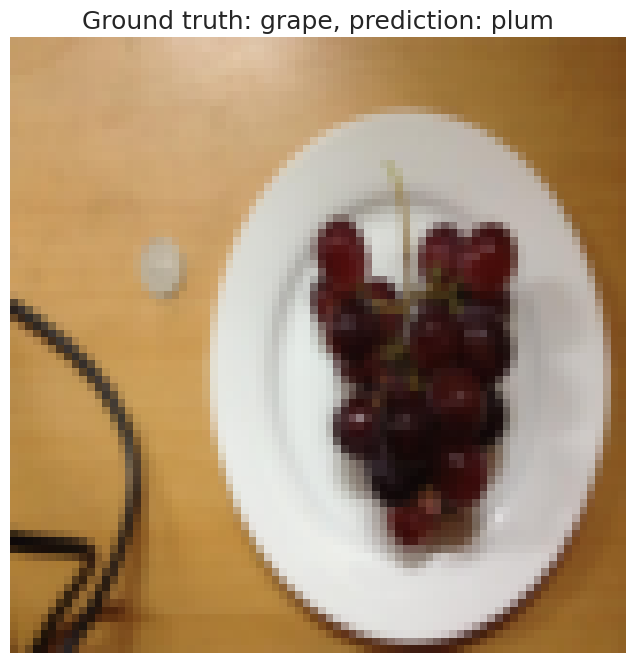

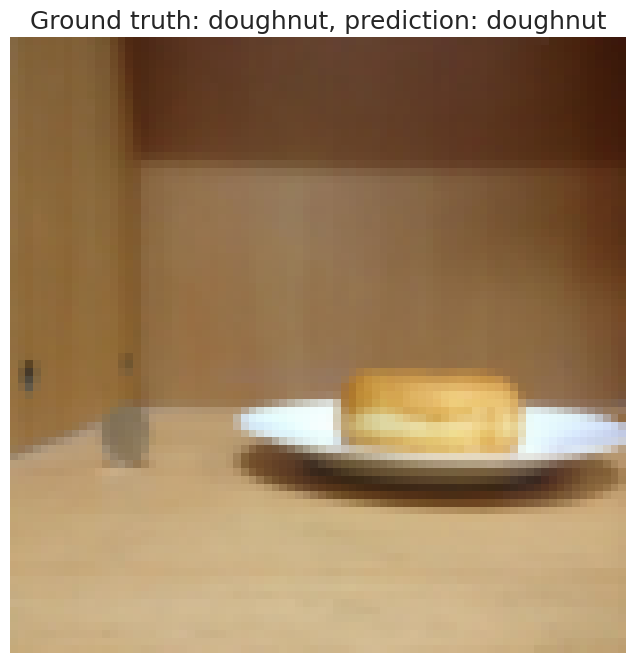

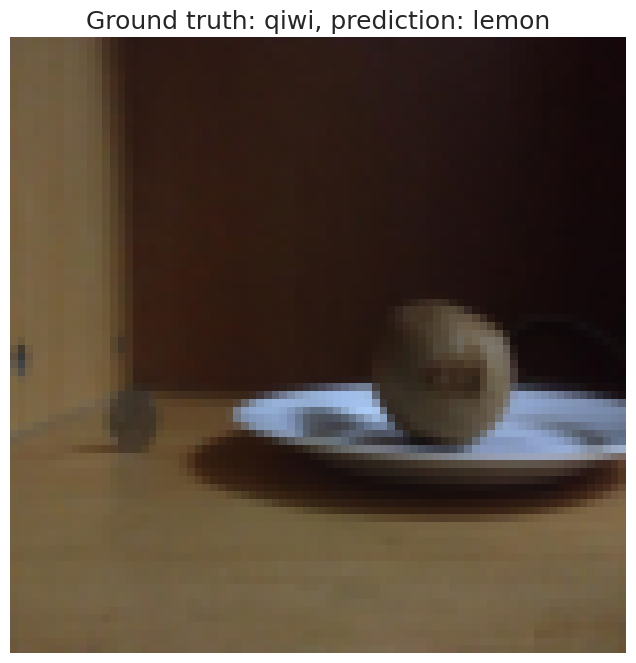

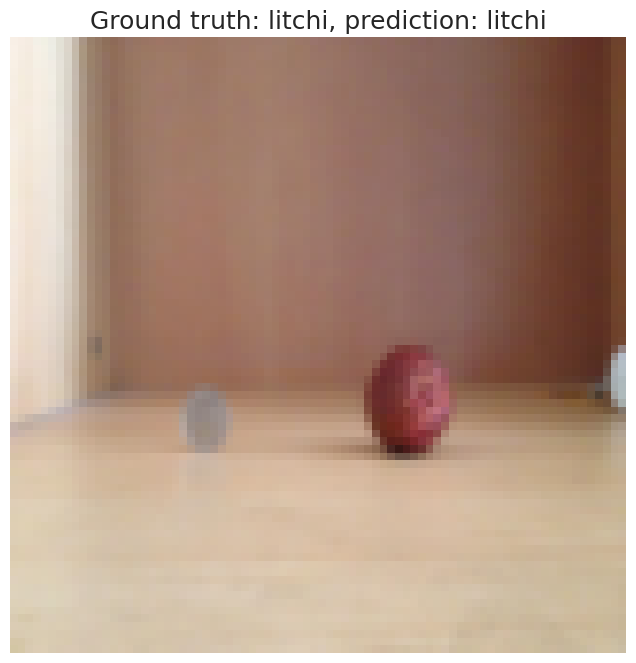

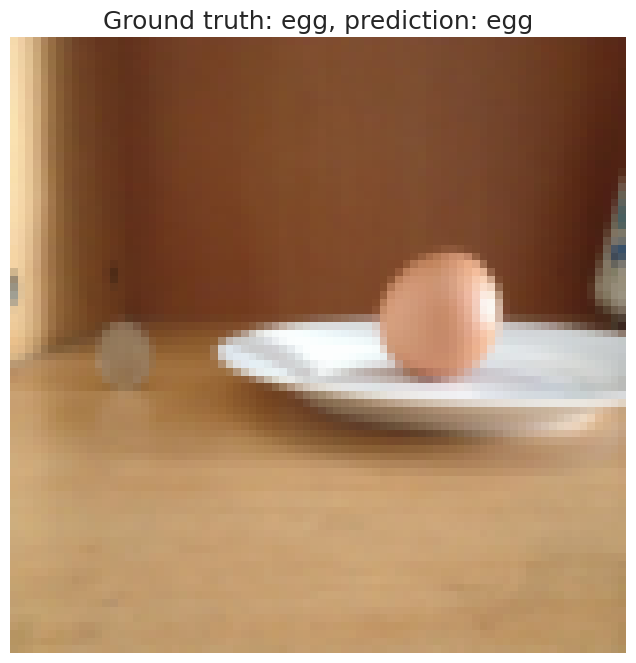

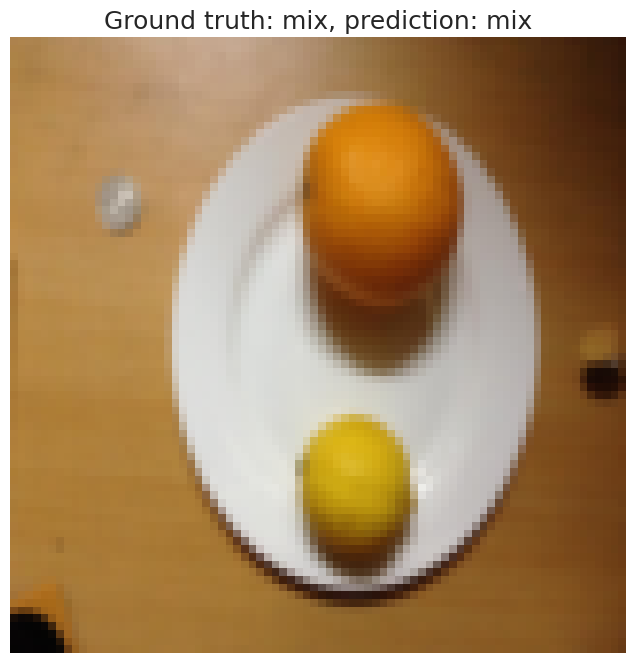

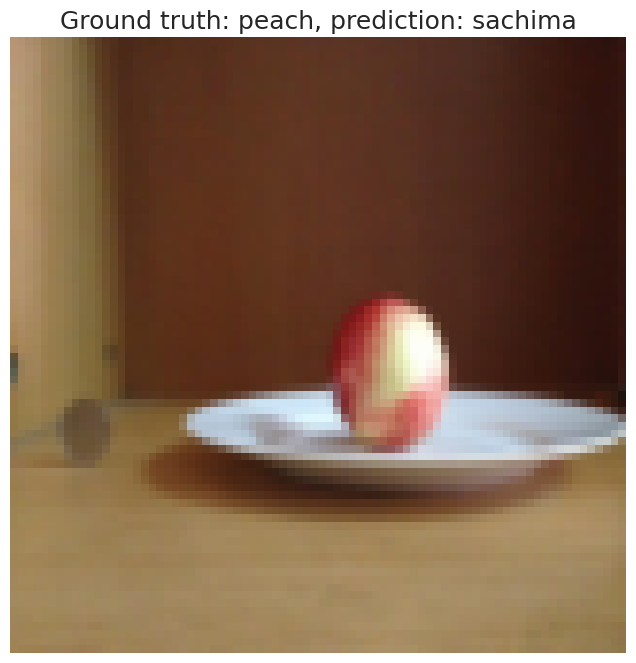

In [ ]:
for i in range(10):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.imshow(X_test[i])
  ax.set_title("Ground truth: " + y_test[i] + ", prediction: " + prediction_RF[i])
  ax.axis('off')
  plt.show()

Let's try to increase the number of estimators:

Accuracy =  0.835


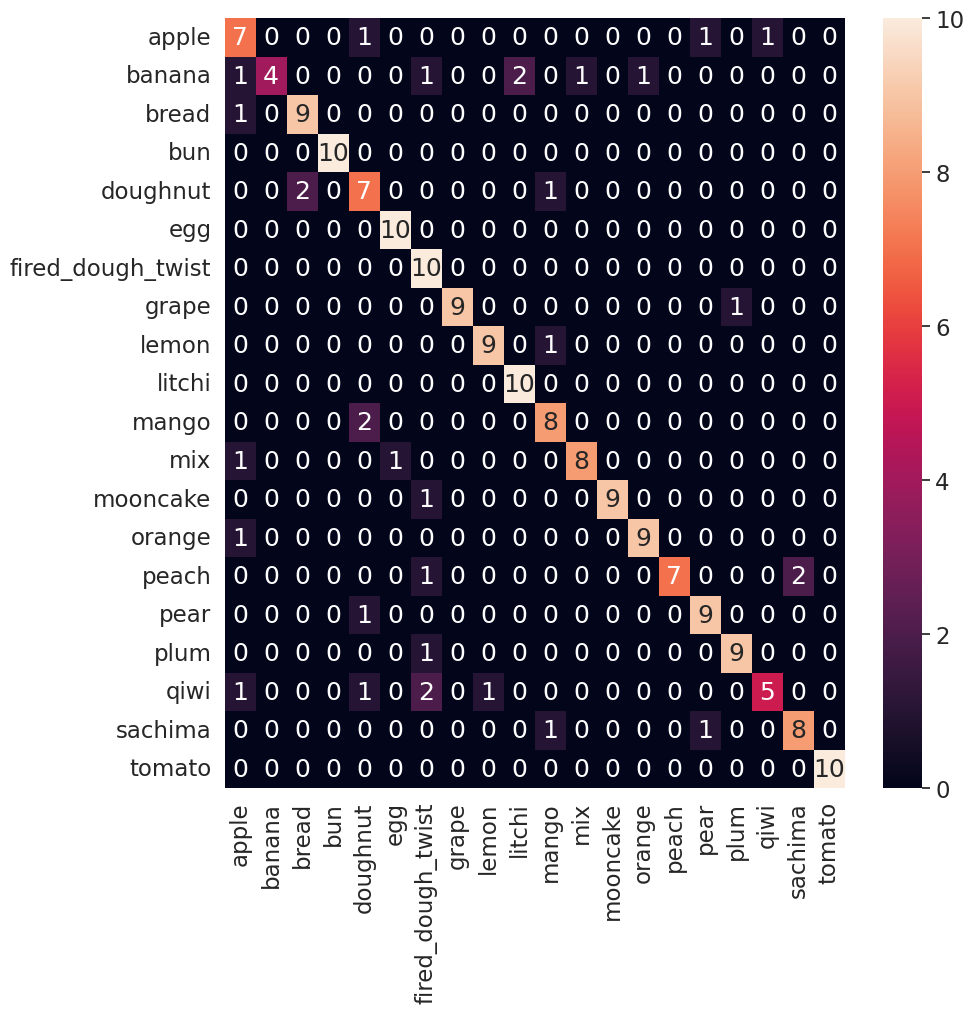

Accuracy =  0.845


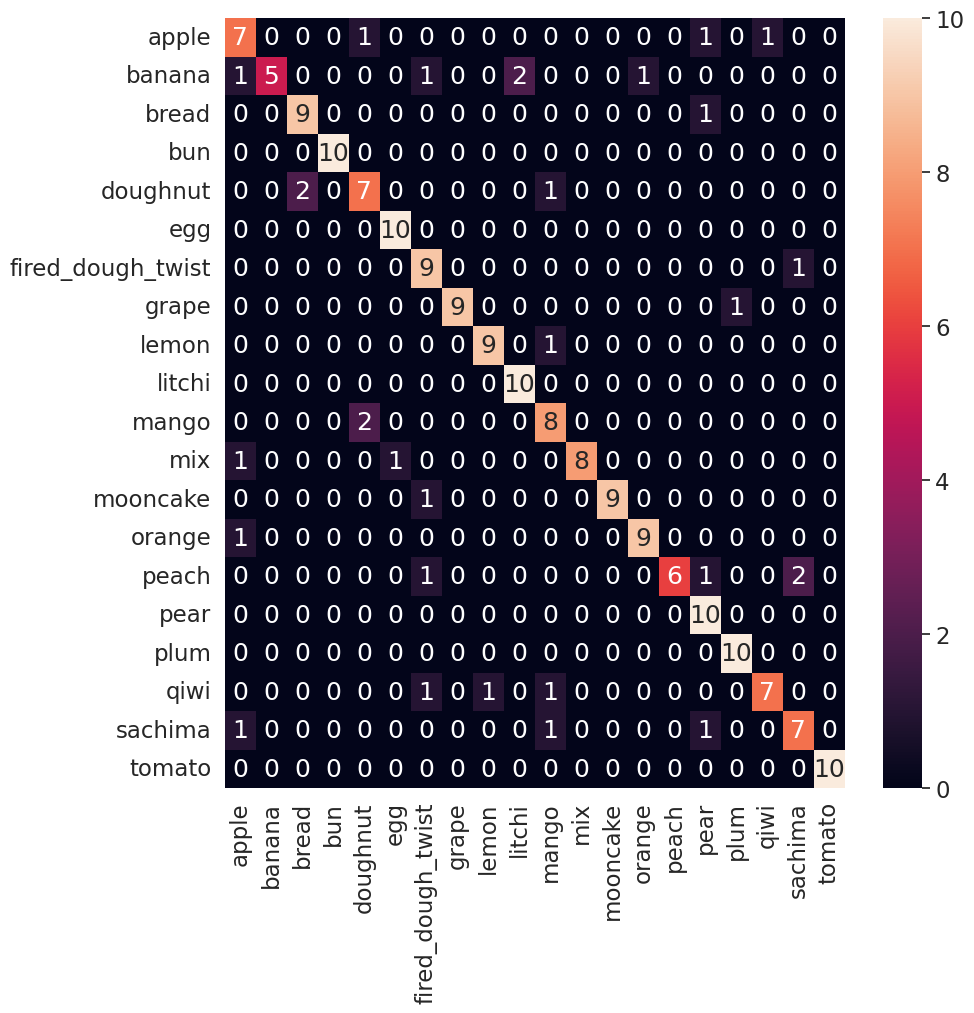

Accuracy =  0.85


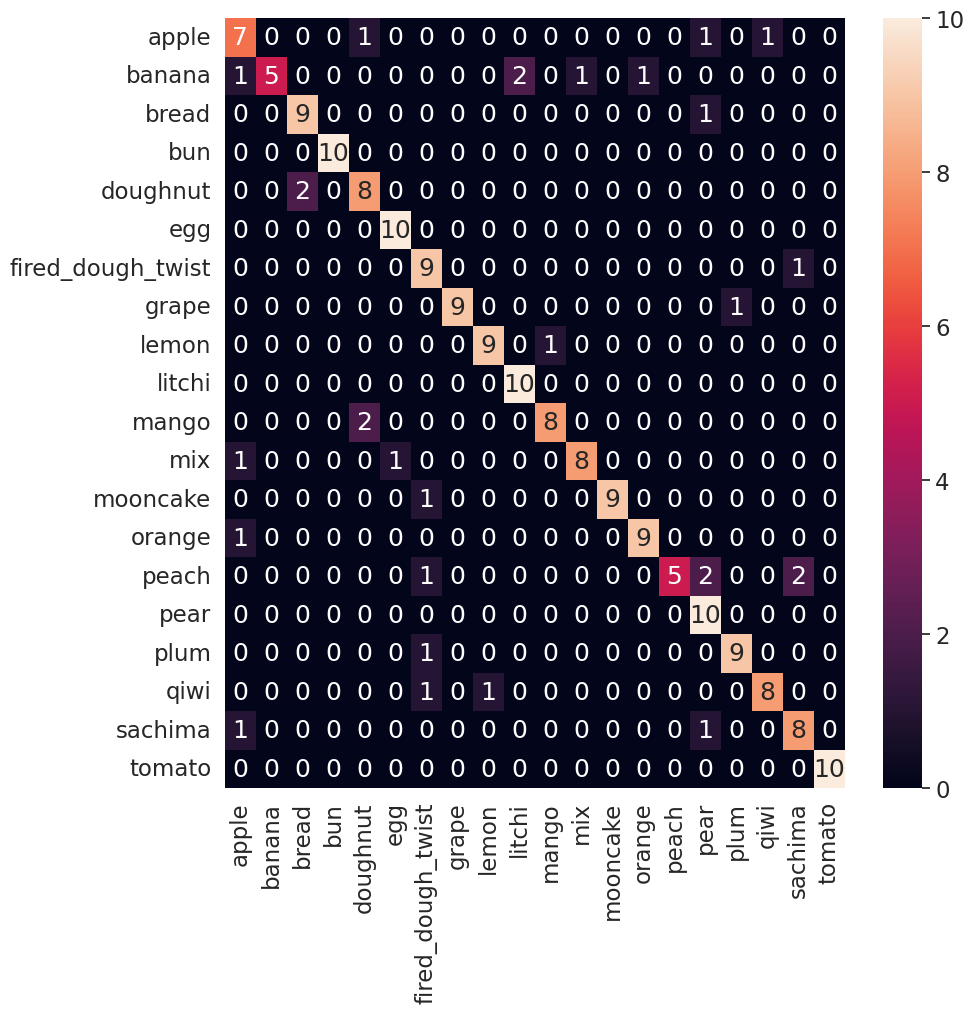

In [ ]:
estimators = [150,200,250]
rf_estimators_cm = []
rf_estimators_cr = []
rf_estimators_scores = []
for i, est in enumerate(estimators):
  RF_model = RandomForestClassifier(n_estimators = est, random_state = 42)

  X_train_f = X_train.reshape(X_train_prepared.shape[0], -1)
  RF_model.fit(X_train_f, y_train)

  X_test_f = X_test.reshape(X_test_prepared.shape[0], -1)
  prediction_RF = RF_model.predict(X_test_f)
  rf_estimators_scores.append(metrics.accuracy_score(y_test, prediction_RF))
  print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

  rf_estimators_cm.append(confusion_matrix(y_test, prediction_RF))
  rf_estimators_cr.append(classification_report(y_test, prediction_RF, output_dict=False, target_names=cls))
  plt.figure(figsize=(10, 10))
  sns.heatmap(rf_estimators_cm[i], annot=True, xticklabels=sorted(np.unique(y_test)), yticklabels=sorted(np.unique(y_test)))
  plt.show()

In [ ]:
for i in range(len(rf_estimators_cr)):
  print(rf_estimators_cr[i])

                   precision    recall  f1-score   support

            apple       0.58      0.70      0.64        10
           banana       1.00      0.40      0.57        10
            bread       0.82      0.90      0.86        10
              bun       1.00      1.00      1.00        10
         doughnut       0.58      0.70      0.64        10
              egg       0.91      1.00      0.95        10
fired_dough_twist       0.62      1.00      0.77        10
            grape       1.00      0.90      0.95        10
            lemon       0.90      0.90      0.90        10
           litchi       0.83      1.00      0.91        10
            mango       0.73      0.80      0.76        10
              mix       0.89      0.80      0.84        10
         mooncake       1.00      0.90      0.95        10
           orange       0.90      0.90      0.90        10
            peach       1.00      0.70      0.82        10
             pear       0.82      0.90      0.86       

We can see that Random Forest with 250 estimators is doing a good job, 85% accuracy.

Now let's save our results on disk:

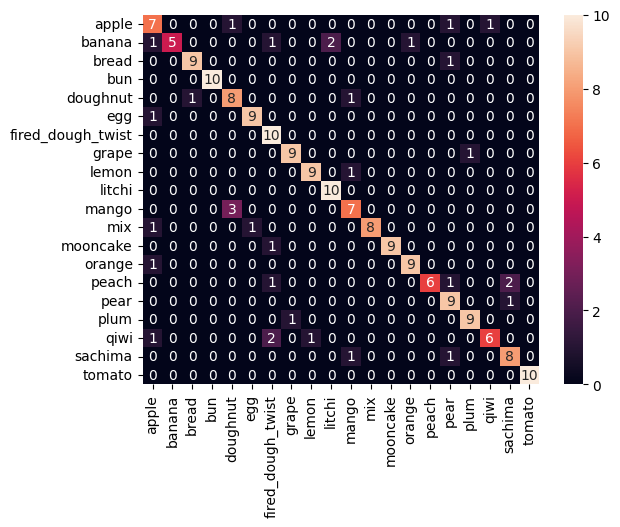

In [ ]:
sns.heatmap(cm_rf_hog_data, annot=True, xticklabels=sorted(cls), yticklabels=sorted(cls))
plt.savefig('/content/drive/MyDrive/ColabNotebooks/models/rf_hog.jpg')

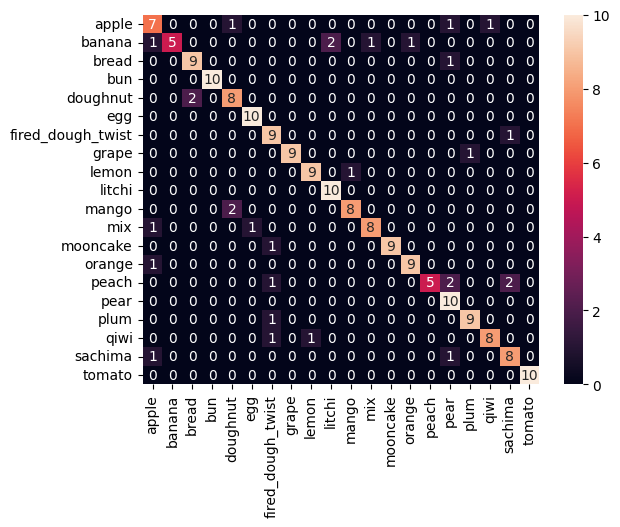

In [ ]:
sns.heatmap(best_rf_est_cm, annot=True, xticklabels=sorted(cls), yticklabels=sorted(cls))
plt.savefig('/content/drive/MyDrive/ColabNotebooks/models/rf_best.jpg')

In [ ]:
best_rf_est_cm = rf_estimators_cm[2].copy()
best_rf_est_cr = rf_estimators_cr[2]
best_rf_score = rf_estimators_scores[2]

In [ ]:
with open('/content/drive/MyDrive/ColabNotebooks/models/rf_results.pkl', 'wb') as f:
    pickle.dump([rf_hog, cm_rf_hog_data, rf_hog_cr,best_rf_score, best_rf_est_cm,best_rf_est_cr], f)

with open('/content/drive/MyDrive/ColabNotebooks/models/rf_results.pkl','rb') as f:
    rf_hog, cm_rf_hog_data, rf_hog_cr,best_rf_score, best_rf_est_cm,best_rf_est_cr = pickle.load(f)

print("\n cm_rf_hog: \n", rf_hog)
print("\n cm_rf_hog_data: \n", cm_rf_hog_data)
print("\n rf_hog_cr: \n", rf_hog_cr)
print("\n best_rf_score: \n", best_rf_score)
print("\n rf_estimators_cm: \n", best_rf_est_cm)
print("\n rf_estimators_cr:\n", best_rf_est_cr)


 cm_rf_hog: 
 0.835

 cm_rf_hog_data: 
 [[ 7  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0]
 [ 1  5  0  0  0  0  1  0  0  2  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  8  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  9  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  6  1  0  0  2  0]
 [ 0  0  0  0 

## Random Forest with feature extraction using neural network:

So far we haven't used any neural networks. Let's extract features using VGG16:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

We are resizing our images as original image size crashes colab:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers import BatchNormalization

import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

SIZE = 128  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = []

for directory_path in glob.glob("/content/train/*"):
    label = directory_path.split("train/")[1].split("_")[-1].split("0")[0]
    for img_path in glob.glob(os.path.join(directory_path)):
      if img_path[-3:] in {'JPG'}:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        if label == 'twist':
          train_labels.append('fired_dough_twist')
        else:
          train_labels.append(label)

#Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = []

for directory_path in glob.glob("/content/test/*"):
    label = directory_path.split("test/")[1].split("_")[-1].split("0")[0]
    for img_path in glob.glob(os.path.join(directory_path)):
      if img_path[-3:] in {'JPG'}:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        if label == 'twist':
          test_labels.append('fired_dough_twist')
        else:
          test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Scale pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

6100
6100
200
200


Now we extract features using VGG:

In [ ]:
#Load VGG model with imagenet trained weights but without classifier/fully connected layers to use as feature extractor.
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in VGG_model.layers:
	layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
#Train features
train_feature_extractor=VGG_model.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
#test features
test_feature_extractor=VGG_model.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

print(train_features.shape)
print(test_features.shape)

7/7 [==============================] - 25s 4s/step
(6100, 8192)
(200, 8192)


Now we'll perform PCA on those features, we first find the number of PCA's to give us 95% of the information:

555


Text(0, 0.5, 'Cum variance')

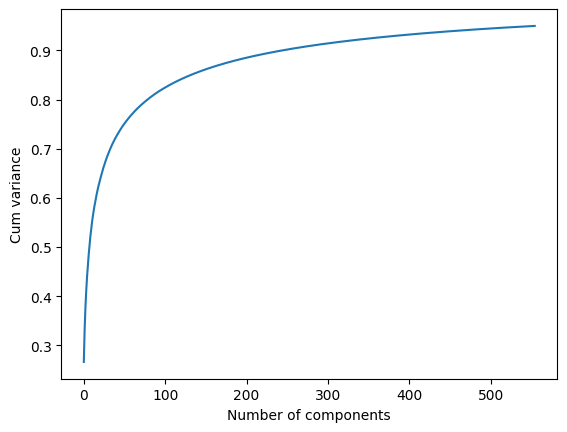

In [ ]:
# Reduce dimensions using PCA
from sklearn.decomposition import PCA

pca_dims = PCA()
pca_dims.fit(train_features)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)
pca_test = PCA(n_components=d)
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")


Now let's see the transformed PCA's:

In [ ]:
pca = PCA(n_components=d)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features)

In [ ]:
import pandas as pd

PC1 = train_PCA[:,0]
PC2 = train_PCA[:,1]
PC3 = train_PCA[:,2]
PC4 = train_PCA[:,3]
zipped = list(zip(PC1,
                  PC2,
                  PC3,
                  PC4))

pc_df = pd.DataFrame(zipped,
                     columns=['PC1',
                              'PC2',
                              'PC3',
                              'PC4'])
pc_df.head()

PC1       PC2       PC3       PC4
0 -10.530832  0.170456 -4.558707  1.193943
1  18.250462 -5.389023 -0.903242 -0.629885
2 -13.609698 -4.798835  1.497905 -3.670321
3  -7.533442 -5.954376  0.755388 -5.488578
4  17.464859 -3.074198 -3.671326 -3.314613

In [ ]:
import plotly.express as px

df = pc_df
features = ["PC1", "PC2", "PC3", "PC4"]

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    train_PCA,
    labels=labels,
    dimensions=range(4),
    color=0
)
fig.update_traces(diagonal_visible=False)
fig.show()

We can see the the PCA's aren't separating our data too well.

Let's try first to classify again with Random Forest on our extracted features:

In [ ]:
cls = list(set(test_labels))

Accuracy =  0.94


<Axes: >

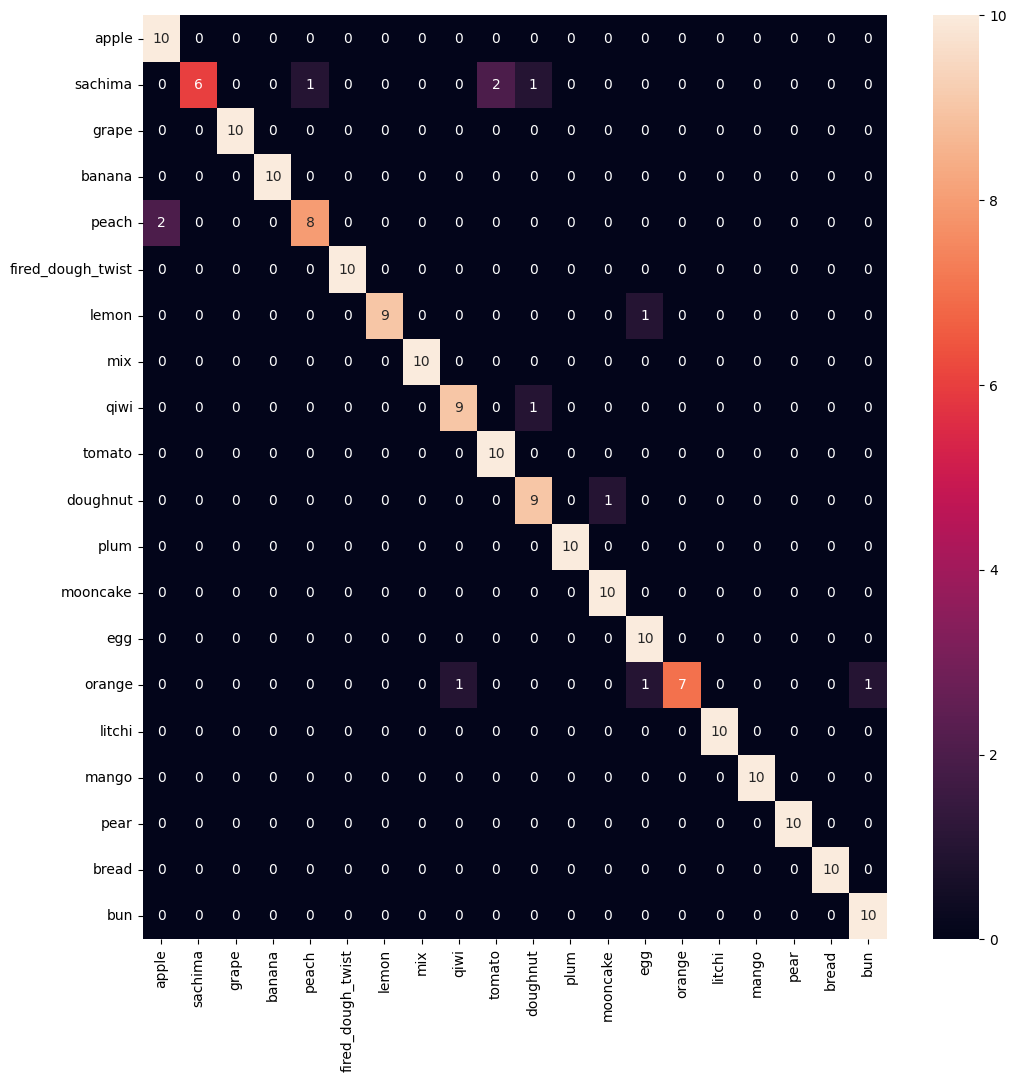

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

RF_model.fit(train_features, y_train)
prediction_RF = RF_model.predict(test_features)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)

rf_vgg_score = metrics.accuracy_score(test_labels, prediction_RF)
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

rf_cm_vgg = confusion_matrix(test_labels, prediction_RF)
plt.figure(figsize=(12, 12))
sns.heatmap(rf_cm_vgg, annot=True, xticklabels=cls, yticklabels=cls)

In [ ]:
cr_rf_vgg = classification_report(test_labels, prediction_RF, output_dict=False, target_names=cls)
print(cr_rf_vgg)

                   precision    recall  f1-score   support

            apple       0.83      1.00      0.91        10
          sachima       1.00      0.60      0.75        10
            grape       1.00      1.00      1.00        10
           banana       1.00      1.00      1.00        10
            peach       0.89      0.80      0.84        10
fired_dough_twist       1.00      1.00      1.00        10
            lemon       1.00      0.90      0.95        10
              mix       1.00      1.00      1.00        10
             qiwi       0.90      0.90      0.90        10
           tomato       0.83      1.00      0.91        10
         doughnut       0.82      0.90      0.86        10
             plum       1.00      1.00      1.00        10
         mooncake       0.91      1.00      0.95        10
              egg       0.83      1.00      0.91        10
           orange       1.00      0.70      0.82        10
           litchi       1.00      1.00      1.00       

It's doing really great, 94% accuracy, much better than with the HOG discriptors, and a lot faster.

Now let's see some neural networks:

## VGG16

We used the model already to extract the features, now we will use it with the final classifing layer for predioction. We encode all the ground truth labels as a one-hot vector:

In [ ]:
#One hot encode y values for neural network.
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

We add the final prediction layer:

In [ ]:
model = Sequential()
inputs = Input(shape=(d,))
hidden = Dense(256, activation='relu')(inputs)
output = Dense(20, activation='softmax')(hidden)
model = Model(inputs=inputs, outputs=output)
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 555)]             0         
                                                                 
 dense (Dense)               (None, 256)               142336    
                                                                 
 dense_1 (Dense)             (None, 20)                5140      
                                                                 
Total params: 147476 (576.08 KB)
Trainable params: 147476 (576.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
import datetime
start = datetime.datetime.now()
model.fit(train_PCA, y_train_one_hot, epochs=20, verbose=1)

model.save("model.h5")
print("Saved model to disk")
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

predict_test = model.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)

Epoch 1/20
191/191 [==============================] - 0s 2ms/step - loss: 7.9891e-05 - categorical_accuracy: 1.0000
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 7.4965e-05 - categorical_accuracy: 1.0000
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 7.0701e-05 - categorical_accuracy: 1.0000
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 6.7416e-05 - categorical_accuracy: 1.0000
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 6.3867e-05 - categorical_accuracy: 1.0000
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 6.0711e-05 - categorical_accuracy: 1.0000
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 5.7975e-05 - categorical_accuracy: 1.0000
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 5.5337e-05 - categorical_accuracy: 1.0000
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss

Let's see how well it did:

Accuracy =  0.985


<Axes: >

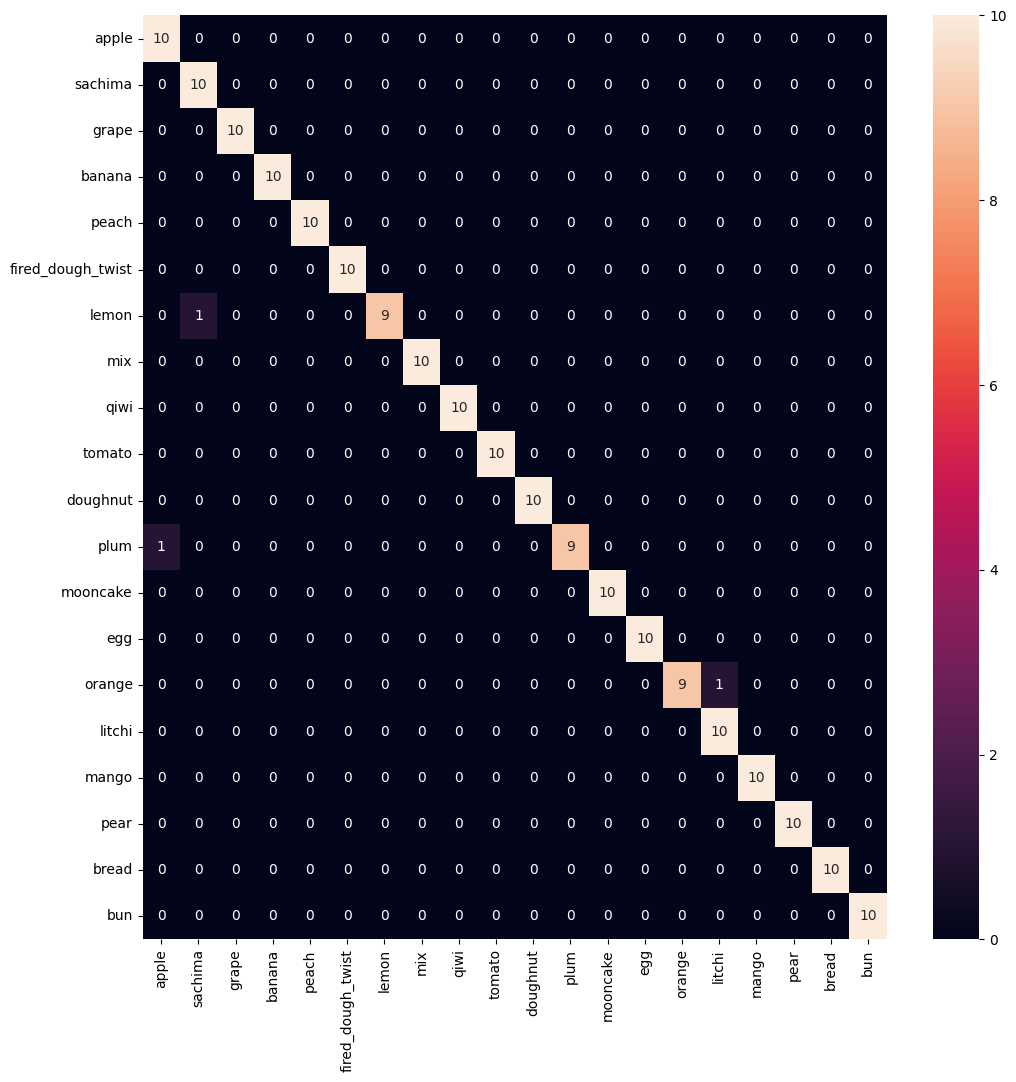

In [ ]:
vgg_acc_score = metrics.accuracy_score(test_labels, predict_test)
print ("Accuracy = ", metrics.accuracy_score(test_labels, predict_test))
cm_vgg = confusion_matrix(test_labels, predict_test)
plt.figure(figsize=(12, 12))
sns.heatmap(cm_vgg, annot=True, xticklabels=cls, yticklabels=cls)

In [ ]:
from sklearn.metrics import classification_report
cr_vgg = classification_report(test_labels, predict_test, output_dict=False, target_names=cls)
print(cr_vgg)

                   precision    recall  f1-score   support

            apple       0.91      1.00      0.95        10
          sachima       0.91      1.00      0.95        10
            grape       1.00      1.00      1.00        10
           banana       1.00      1.00      1.00        10
            peach       1.00      1.00      1.00        10
fired_dough_twist       1.00      1.00      1.00        10
            lemon       1.00      0.90      0.95        10
              mix       1.00      1.00      1.00        10
             qiwi       1.00      1.00      1.00        10
           tomato       1.00      1.00      1.00        10
         doughnut       1.00      1.00      1.00        10
             plum       1.00      0.90      0.95        10
         mooncake       1.00      1.00      1.00        10
              egg       1.00      1.00      1.00        10
           orange       1.00      0.90      0.95        10
           litchi       0.91      1.00      0.95       

Let's see some predictions:

1/1 [==============================] - 0s 72ms/step


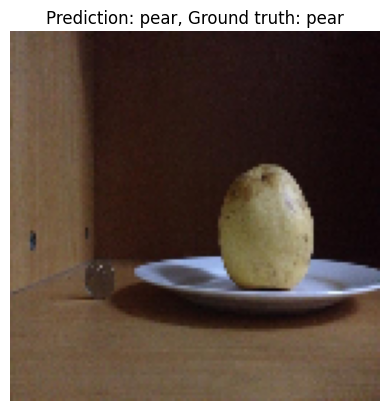

1/1 [==============================] - 0s 38ms/step


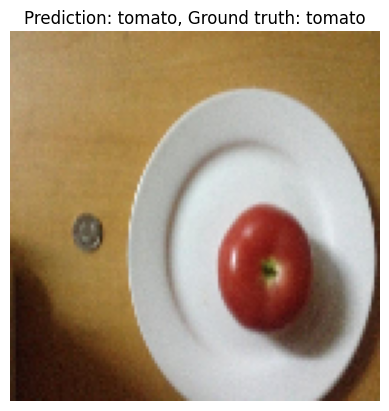

1/1 [==============================] - 0s 48ms/step


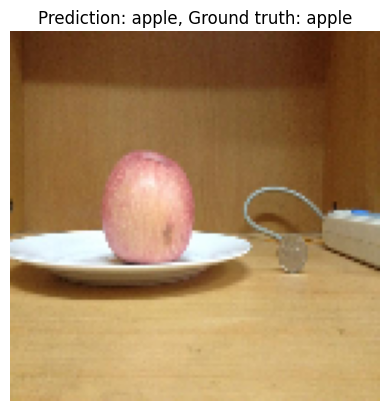

1/1 [==============================] - 0s 23ms/step


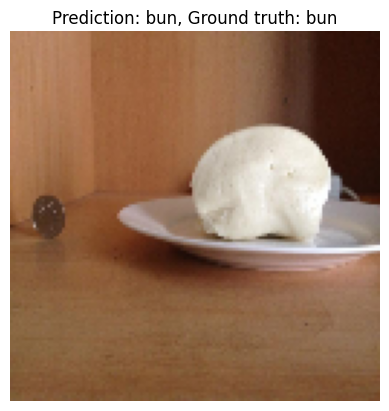

1/1 [==============================] - 0s 30ms/step


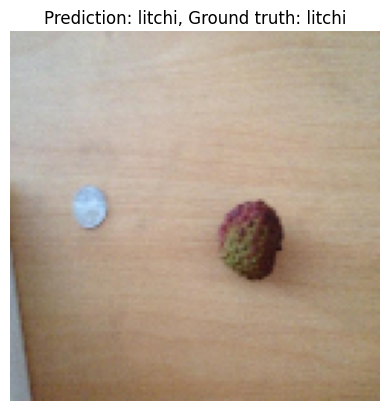

1/1 [==============================] - 0s 33ms/step


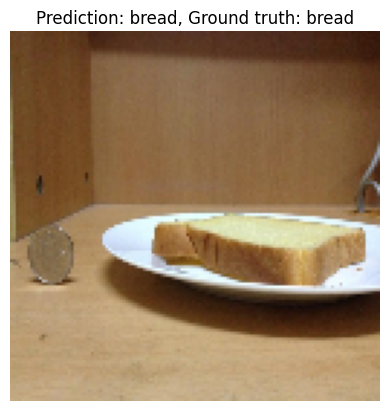

1/1 [==============================] - 0s 23ms/step


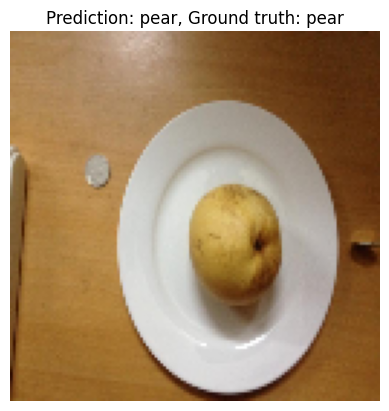

1/1 [==============================] - 0s 28ms/step


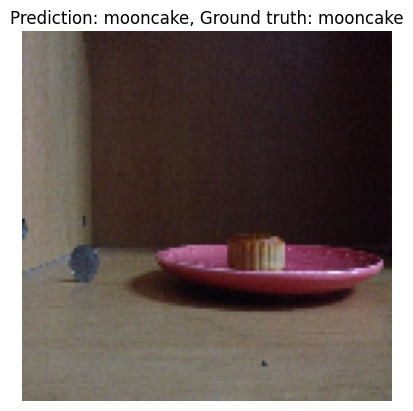

1/1 [==============================] - 0s 33ms/step


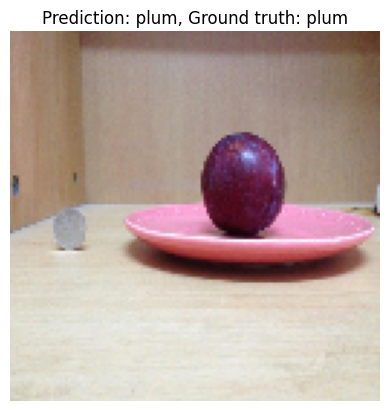

1/1 [==============================] - 0s 23ms/step


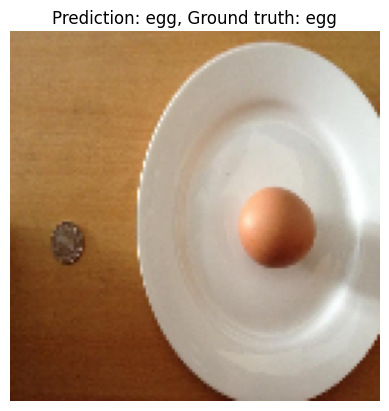

1/1 [==============================] - 0s 28ms/step


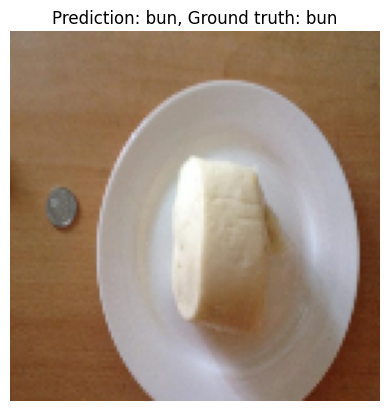

1/1 [==============================] - 0s 87ms/step


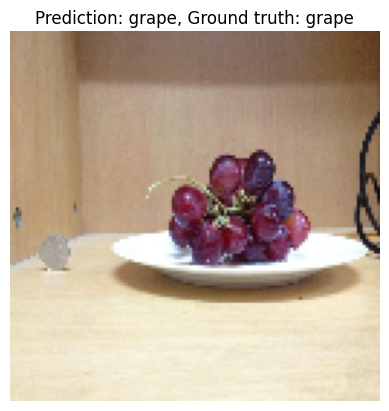

1/1 [==============================] - 0s 71ms/step


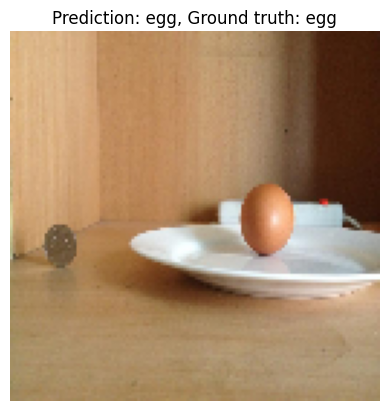

1/1 [==============================] - 0s 45ms/step


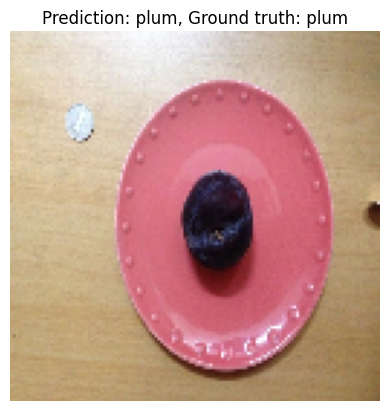

1/1 [==============================] - 0s 43ms/step


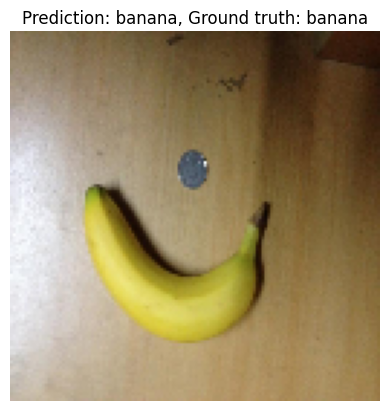

1/1 [==============================] - 0s 66ms/step


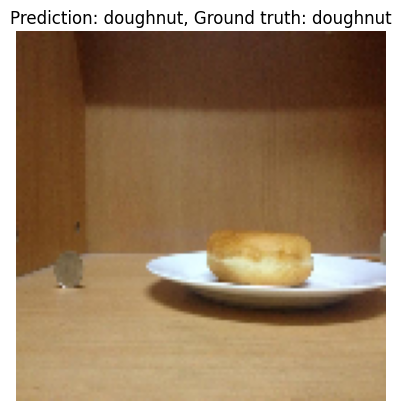

1/1 [==============================] - 0s 41ms/step


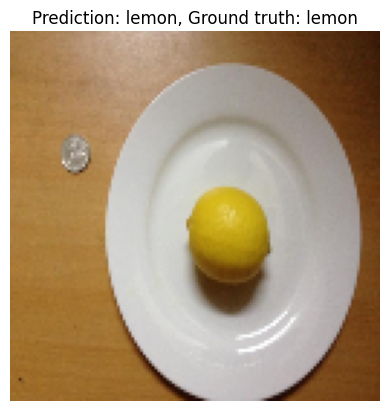

1/1 [==============================] - 0s 71ms/step


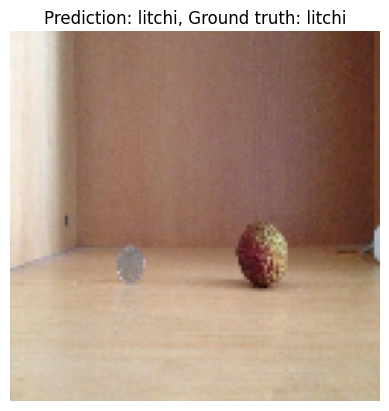

1/1 [==============================] - 0s 82ms/step


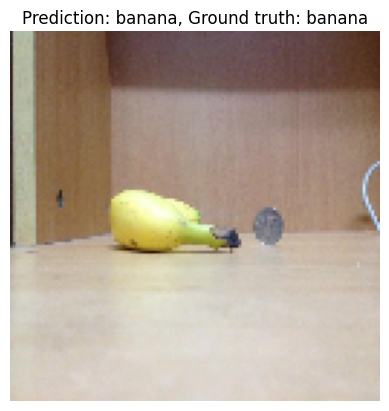

1/1 [==============================] - 0s 67ms/step


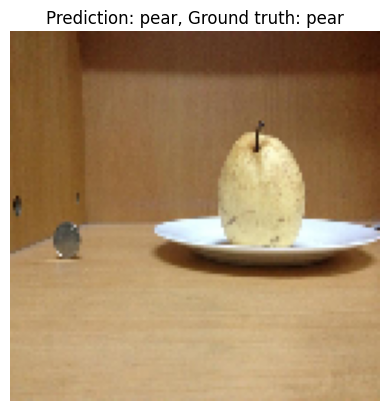

In [ ]:
for i in range(20):
  n=np.random.randint(0, x_test.shape[0])
  img = x_test[n]
  input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
  input_img_feature=VGG_model.predict(input_img)
  input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
  input_img_PCA = pca.transform(input_img_features)
  prediction_img = model.predict(input_img_PCA)
  prediction_img = np.argmax(prediction_img, axis=1)
  prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
  plt.imshow(img)
  plt.title("Prediction: " + prediction_img[0] + ", Ground truth: " + test_labels[n])
  plt.axis('off')
  plt.show()

98.5% accuracy! It's gonna be hard to surpass.Llet's save our results:

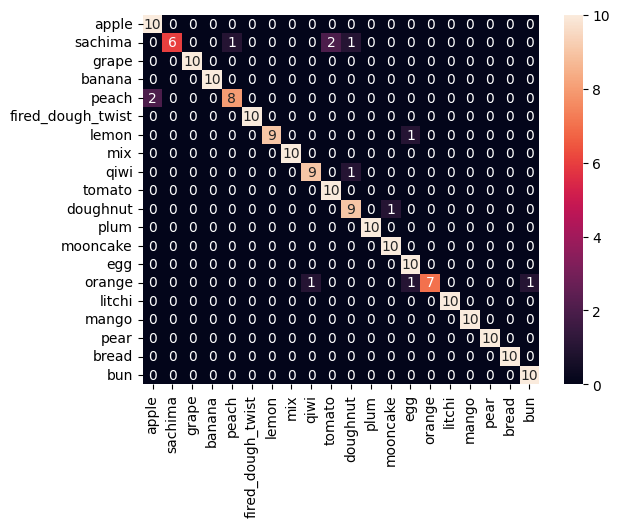

In [ ]:
sns.heatmap(rf_cm_vgg, annot=True, xticklabels=cls, yticklabels=cls)
plt.savefig('/content/drive/MyDrive/ColabNotebooks/models/rf_cm_vgg.jpg')


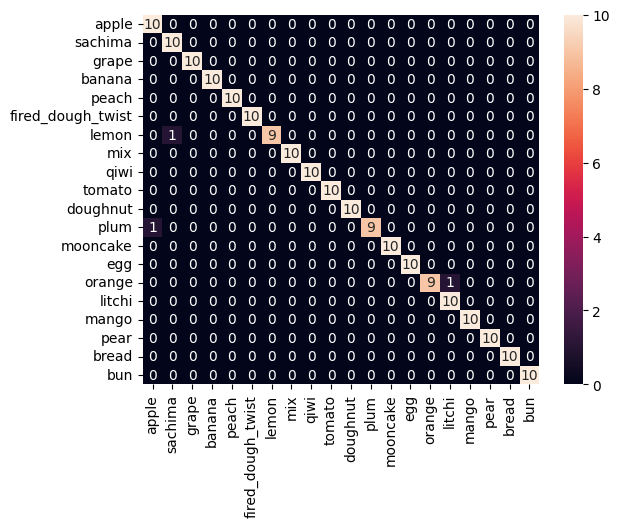

In [ ]:
sns.heatmap(cm_vgg, annot=True, xticklabels=cls, yticklabels=cls)
plt.savefig('/content/drive/MyDrive/ColabNotebooks/models/cm_vgg.jpg')

In [ ]:
with open('/content/drive/MyDrive/ColabNotebooks/models/VGG_results.pkl', 'wb') as f:
    pickle.dump([rf_vgg_score,rf_cm_vgg,cr_rf_vgg,vgg_acc_score, cm_vgg,cr_vgg], f)

with open('/content/drive/MyDrive/ColabNotebooks/models/VGG_results.pkl','rb') as f:
    rf_vgg_score,rf_cm_vgg,vgg_acc_score, cr_rf_vgg,cm_vgg,cr_vgg = pickle.load(f)

print("\n rf_vgg_score: \n", rf_vgg_score)
print("\n rf_cm_vgg: \n", rf_cm_vgg)
print("\n cr_rf_vgg: \n", cr_rf_vgg)
print("\n vgg_acc_score:\n", vgg_acc_score)
print("\n cm_vgg: \n", cm_vgg)
print("\n cr_vgg: \n", cr_vgg)


 rf_vgg_score: 
 0.94

 rf_cm_vgg: 
 [[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  1  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  1  7  0  0  0  0  1]
 [ 0  0  0  0  0 

## Classification summary:
So far we have seen how the results of several models:
1. SGD + HOG discriptors - 55% accuracy
2. SVM + HOG using grid search - 77% accuracy
3. Random Forest:

  a. HOG discriptors with 100 estimators - 83.5% accuracy

  b. HOG discriptors with different number of estimators - 150,200,250. on 250- 85% accuracy

  c. extracted features using VGG16 - 94% accuracy

4. VGG16 neural network with PCA on extracted features - 98.5% accuracy

We saved all the data to disk, so we could compare them later.